<a href="https://colab.research.google.com/github/lomidez/Impact-of-Covid/blob/main/Impact_of_COVID_19_on_Energy_Consumption_in_Seattle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The Impact of COVID-19 on Energy Consumption in Seattle**


Report Link: https://drive.google.com/file/d/1Muzh2fnlL6uLeZIs5qgr-4jYWKgSVdWV/view?usp=drive_link


The city of Seattle's Open Data portal is the source for all datasets used in this analysis.
* Four datasets represent energy usage in Seattle, Washington for the years 2016 - 2019. This will be used to train our model on how energy was used pre-lockdown.
* Two datasets represent energy usage in Seattle, Washington for the two years 2020 - 2021. This will be used to test the difference between the projected and actual energy usage.
* The dataset below represents energy usage in Seattle for calender year 2016.
** https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy



* We are going to begin by importing packages used in our analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import missingno as msno
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt

* We need to load all available energy datasets from Seattle's Open Data Portal into dataframes:

In [2]:
# Load CSV files from Seattle Open Data Portal
# 2016-2019 will be used to train our model
df_2016 = pd.read_csv('https://data.seattle.gov/resource/2bpz-gwpy.csv')
df_2017 = pd.read_csv('https://data.seattle.gov/resource/qxjw-iwsh.csv')
df_2018 = pd.read_csv('https://data.seattle.gov/resource/ypch-zswb.csv')
df_2019 = pd.read_csv('https://data.seattle.gov/resource/3th6-ticf.csv')
# 2020-2021 will be used to test our prediction
df_2020 = pd.read_csv('https://data.seattle.gov/resource/auez-gz8p.csv')
df_2021 = pd.read_csv('https://data.seattle.gov/resource/bfsh-nrm6.csv')

# **Data Preprocessing**

## Dropping Redundant Columns
Lets start by looking at the dimmensions of our datasets:

In [3]:
print("2016 columns: " + str(df_2016.shape[1]))
print("2017 columns: " + str(df_2017.shape[1]))
print("2018 columns: " + str(df_2018.shape[1]))
print("2019 columns: " + str(df_2019.shape[1]))
print("2020 columns: " + str(df_2020.shape[1]))
print("2021 columns: " + str(df_2021.shape[1]))

2016 columns: 46
2017 columns: 45
2018 columns: 41
2019 columns: 42
2020 columns: 42
2021 columns: 42


These datasets contain many columns that we don't want to include as features in our analysis. furthermore, some columns are also not represented in all datasets. We will start our data cleaning by reducing and normalizing the dimensions of our tables. <br> <br>
We mention the reasoning for dropping several preliminary columns below:

* Firstly, let's drop unnecessary variables that do not contain valuable information for predictions. The column descriptions of the following variables helped us initially weed out unneeded features in our dataset:

1. `address` -  Redundant variable, we have lat/long coordinates for building sites.
2. `propertyname` - unique property names are not informative for deriving energy usage.
3. `osebuildingid` - A unique identifier assigned by the city. Not informative.
4. `neighborhood` - Property neighborhood area defined by the City of Seattle Department of Neighborhoods.
5. `largest_property_use_type` - The same as `PrimaryPropertyType` so drop
6. `numberofbuildings` - This variable appears only in 2016 and 2017 years, it is missing in all other datasets
7. `yearsenergystarcertified` - This variable appears only in 2016 and 2017 years, it is missing in all other datasets

In [4]:
# City:
print("Unique city entries:")
print(df_2021["city"].unique())
# State:
print("Unique state entries:")
print(df_2021["state"].unique())

Unique city entries:
['SEATTLE']
Unique state entries:
['WA']


* `city` and `state` are redundant columns, each with only 1 value. All data is from Seattle, Washington, so there columns aren't useful. We'll add them as columns to be dropped. <br>

* Several of the datasets' columns don't include information about energy, and were used by the city for other reasons. They are mostly sparsely populated and otherwise not very useful for our purpose:

* `taxparcelidentificationnumber`, `yearsenergystarcertified`, `comments`, all hold categorical data that doesn't relate to direct energy usage:

In [5]:
df_2016[['taxparcelidentificationnumber','yearsenergystarcertified', 'comments']].head()

,taxparcelidentificationnumber,yearsenergystarcertified,comments
0,659000030,NaN,NaN
1,659000220,NaN,NaN
2,659000475,NaN,NaN
3,659000640,NaN,NaN
4,659000970,NaN,NaN


* `largestpropertyusetype`,
 `listofallpropertyusetypes`, `secondlargestpropertyusetype`, `thirdlargestpropertyusetype`, `numberofbuildings` all hold information about property type.
 * They describe secondary uses for the property, like if a building has a parking lot.
 * We don't intend to analyze these features, and so we drop them to help reduce complexity in our data.

In [6]:
df_2016[['largestpropertyusetype', 'listofallpropertyusetypes','secondlargestpropertyusetype', 'thirdlargestpropertyusetype', 'numberofbuildings']].head()

,largestpropertyusetype,listofallpropertyusetypes,secondlargestpropertyusetype,thirdlargestpropertyusetype,numberofbuildings
0,Hotel,Hotel,NaN,NaN,1.0
1,Hotel,"Hotel, Parking, Restaurant",Parking,Restaurant,1.0
2,Hotel,Hotel,NaN,NaN,1.0
3,Hotel,Hotel,NaN,NaN,1.0
4,Hotel,"Hotel, Parking, Swimming Pool",Parking,Swimming Pool,1.0


* `outlier` and `defaultdata` aren't very useful to us. We want to identify our own outliers based on our analysis, and the datasets as they are currently are default to us. Removing these columns will help remove confusion.

In [7]:
df_2016[['defaultdata', 'outlier']].head()

,defaultdata,outlier
0,False,NaN
1,False,NaN
2,False,NaN
3,False,NaN
4,False,NaN


* We next create a `drop_columns` variable to hold these identified columns.
This variable will be used to begin reducing the dimensions of our features. It will also help us make the shape of our eventual training set equal the shape of our test set.

In [8]:
# These columns aren't going to help us determine energy usage statistics, se we will remove them
drop_columns = ['osebuildingid','address', 'propertyname', 'neighborhood', 'city', 'state', 'taxparcelidentificationnumber',
                'listofallpropertyusetypes','secondlargestpropertyusetype', 'thirdlargestpropertyusetype',
                'comments', 'defaultdata', 'outlier', 'largestpropertyusetype', 'numberofbuildings', 'yearsenergystarcertified']

#osebuildingid, largestpropertyusetype, numberofbuildings, yearsenergystarcertified

# Apply the drop_columns variable to the datasets
df_2016 = df_2016.drop(columns = drop_columns)
df_2017 = df_2017[df_2016.columns]

## Standardizing Column Names
The 6 datasets have different naming conventions for some columns. Below, we standardize the column names:

In [9]:
# Some columns in the different datasets have different column names, standardize names for all our columns
df_2018 = df_2018.rename(columns={'ose_building_id': 'osebuildingid', 'data_year': 'datayear',
                        'building_name': 'propertyname', 'ghg_emissions_intensity': 'ghgemissionsintensity',
                                  'zip_code': 'zipcode', 'year_built': 'yearbuilt',
                                  'council_district_code': 'councildistrictcode', 'building_type' : 'buildingtype',
                                  'numberof_floors': 'numberoffloors', 'property_gfa_total': 'propertygfatotal',
                                  'largest_property_use_type_1': 'largestpropertyusetypegfa', 'property_gfa_parking': 'propertygfaparking',
                                  'second_largest_property_use_1': 'secondlargestpropertyuse', 'third_largest_property_use_1': 'thirdlargestpropertyusetypegfa',
                                  'energystar_score': 'energystarscore', 'compliance_status': 'compliancestatus',
                                  'total_ghg_emissions': 'totalghgemissions', 'primary_property_type' : 'primarypropertytype'})[df_2016.columns]

df_2019 = df_2019.rename(columns={'buildingname':'propertyname'})[df_2016.columns]
df_2020 = df_2020.rename(columns={'buildingname':'propertyname', 'epapropertytype':'primarypropertytype'})[df_2016.columns]
df_2021 = df_2021.rename(columns={'buildingname':'propertyname', 'epapropertytype':'primarypropertytype'})[df_2016.columns]

Now that our six datasets have been standardized and dimmensionally reduced, lets split them into our training and test data.
* First, lets verify the shape of all datasets are the same before we merge them:

In [10]:
print("2016 column count = ("  + str(df_2016.shape[1]) + ")")
print("2017 column count = ("  + str(df_2017.shape[1]) + ")")
print("2018 column count = ("  + str(df_2018.shape[1]) + ")")
print("2019 column count = ("  + str(df_2019.shape[1]) + ")")
print("2020 column count = ("  + str(df_2020.shape[1]) + ")")
print("2021 column count = ("  + str(df_2021.shape[1]) + ")")


2016 column count = (30)
2017 column count = (30)
2018 column count = (30)
2019 column count = (30)
2020 column count = (30)
2021 column count = (30)


Now that we have verified equality, our columns are ready to be merged:
* Our training data is going to represent the four years worth of energy usage in Seattle before the Covid-19 pandemic.
* Our test data is going to represent the two years of the lockdown energy usage in Seattle.

In [11]:
# Train Energy Consumption dataset
df_2016_2019_train = pd.concat([df_2016, df_2017, df_2018, df_2019], ignore_index = True)

# Test Energy Consumption dataset
df_2020_2021_test = pd.concat([df_2020, df_2021], ignore_index = True)

Verify the two datasets have a similar number of columns:

In [12]:
print("Training data dimensions (rows, columns) = (" + str(df_2016_2019_train.shape[0]) + "," + str(df_2016_2019_train.shape[1]) + ")")
print("Test data dimensions (row, columns) = (" + str(df_2020_2021_test.shape[0]) + "," + str(df_2020_2021_test.shape[1]) + ")")

Training data dimensions (rows, columns) = (4000,30)
Test data dimensions (row, columns) = (2000,30)


In [13]:
df_2016_2019_train.head().info()
df_2020_2021_test.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   datayear                        5 non-null      int64  
 1   buildingtype                    5 non-null      object 
 2   primarypropertytype             5 non-null      object 
 3   zipcode                         5 non-null      float64
 4   councildistrictcode             5 non-null      float64
 5   latitude                        5 non-null      float64
 6   longitude                       5 non-null      float64
 7   yearbuilt                       5 non-null      int64  
 8   numberoffloors                  5 non-null      int64  
 9   propertygfatotal                5 non-null      int64  
 10  propertygfaparking              5 non-null      float64
 11  propertygfabuilding_s           5 non-null      float64
 12  largestpropertyusetypegfa       5 non-nu

We have succeeded in merging our six original datasets into training and test datasets. However, there are still way too many dimmensions for us to easily verify equality of columns. Lets verify that these two datasets have the same columns:

In [14]:
same_list = df_2020_2021_test.columns == df_2016_2019_train.columns
print("Do the training and test datasets have the same columns?: ")
print(same_list)

Do the training and test datasets have the same columns?: 
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


Now our training and test datasets are created, and we have verified they contain the same features.

## Handling Missing Values
Lets explore the tuples stored in our dataset, and decide how to handle missing values. <br>
The following is a table of columns and the number of missing values within:

In [15]:
#Output table with number of missing values
print("Number of missing values:")
print(df_2016_2019_train.isna().sum()[df_2016_2019_train.isna().sum() > 0])

Number of missing values:
primarypropertytype                 13
zipcode                              7
councildistrictcode                  3
latitude                             3
longitude                            3
propertygfaparking                 185
propertygfabuilding_s              185
largestpropertyusetypegfa           23
secondlargestpropertyuse          1726
thirdlargestpropertyusetypegfa    3018
energystarscore                   1106
siteeui_kbtu_sf                     53
siteeuiwn_kbtu_sf                   82
sourceeui_kbtu_sf                   52
sourceeuiwn_kbtu_sf                 81
siteenergyuse_kbtu                  74
siteenergyusewn_kbtu                60
steamuse_kbtu                      917
electricity_kwh                     12
electricity_kbtu                    12
naturalgas_therms                  318
naturalgas_kbtu                    318
totalghgemissions                    2
ghgemissionsintensity                2
dtype: int64


Lets find out how frequent these missing values are in our training set in order to decide how to replace the missing value:

In [16]:
# Generate the percentage of missing values within each column
print("Fraction of missing values:")
(df_2016_2019_train.isnull().sum() * 100 / len(df_2016_2019_train))[df_2016_2019_train.isnull().sum() * 100 / len(df_2016_2019_train) > 0]

Fraction of missing values:


,0
primarypropertytype,0.325
zipcode,0.175
councildistrictcode,0.075
latitude,0.075
longitude,0.075
propertygfaparking,4.625
propertygfabuilding_s,4.625
largestpropertyusetypegfa,0.575
secondlargestpropertyuse,43.150
thirdlargestpropertyusetypegfa,75.450


### Missingness Matrix
To identify trends in how missing values are represented in our data, lets visually see the missiness matrices of our training and test datasets.

(4000, 24)


<Axes: >

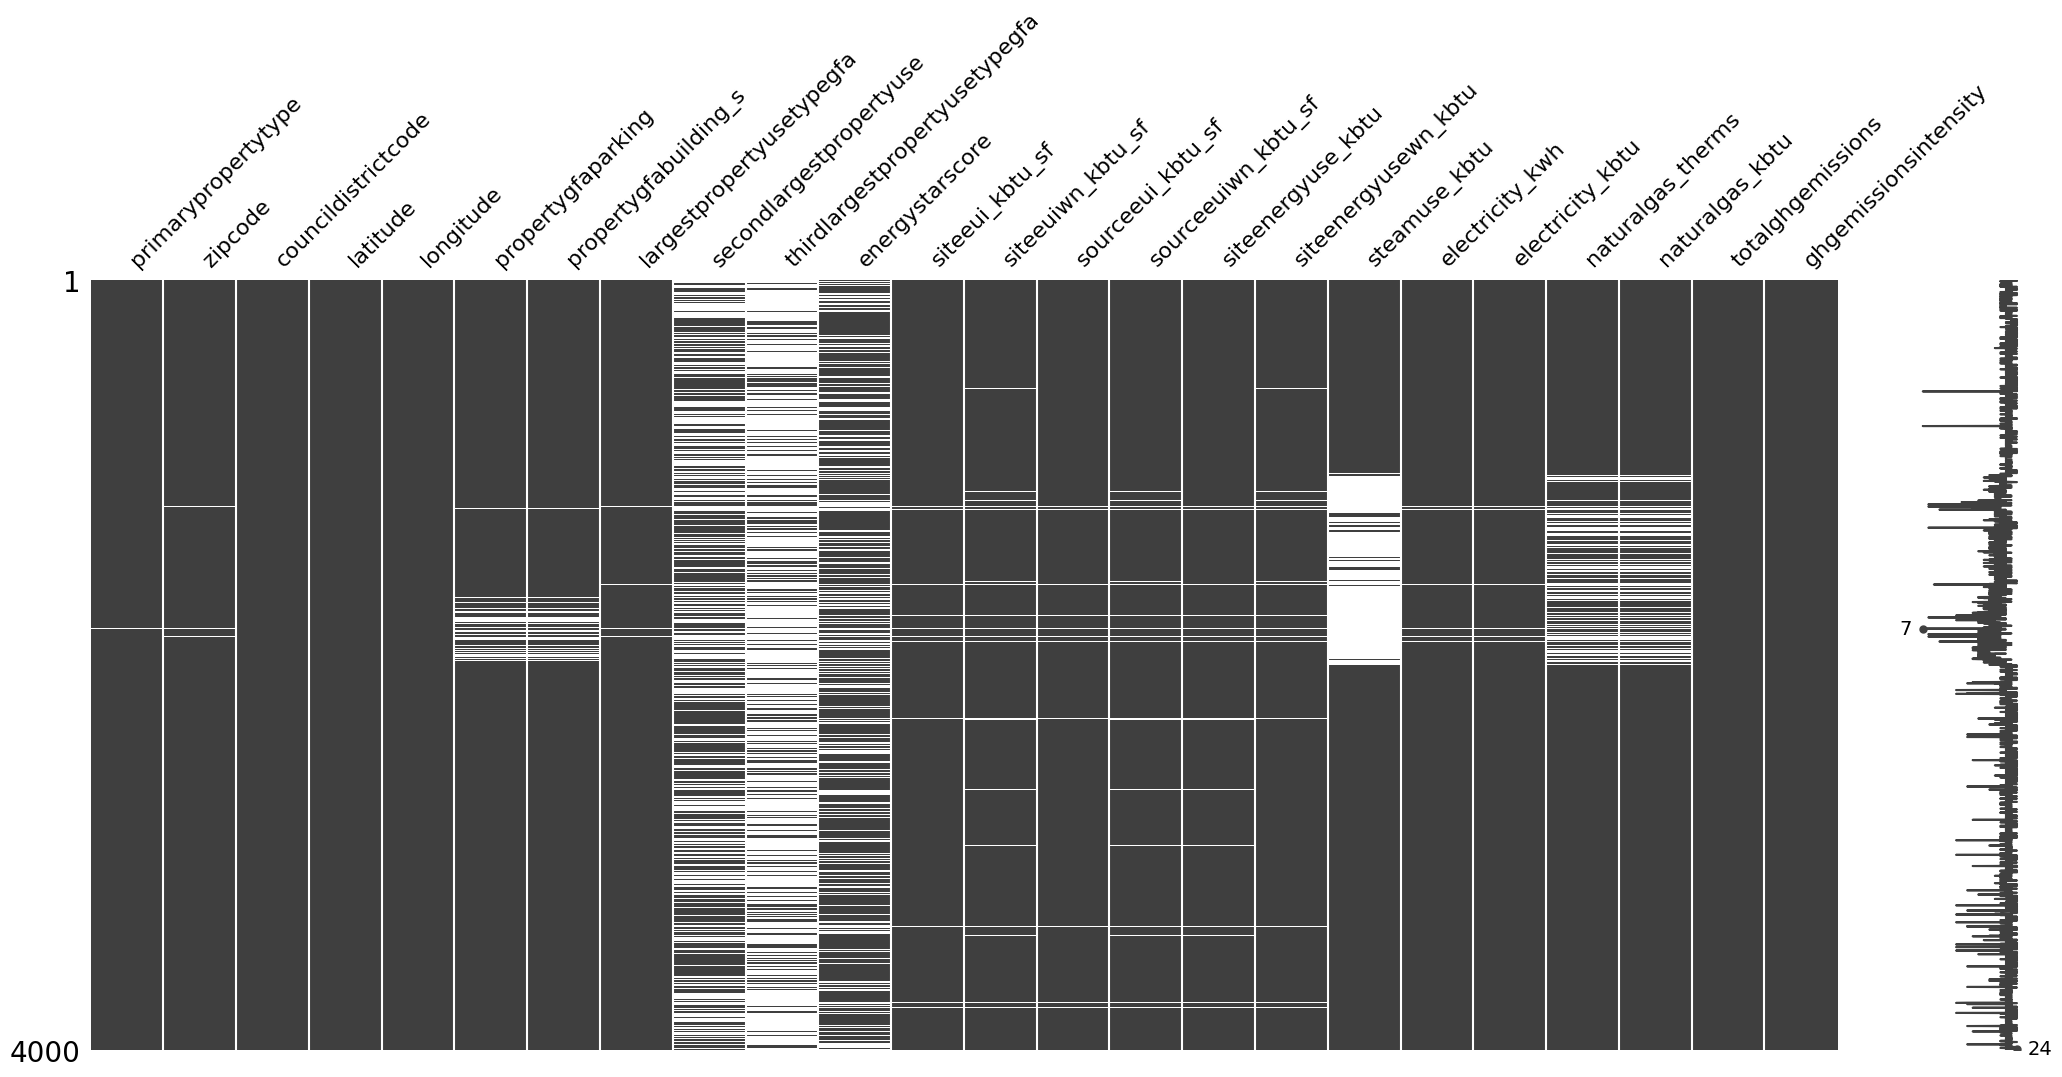

In [17]:
# Create the missingness matrix of missing values for training
df_nulls_train = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
print(df_nulls_train.shape)
msno.matrix(df_nulls_train)

(2000, 15)


<Axes: >

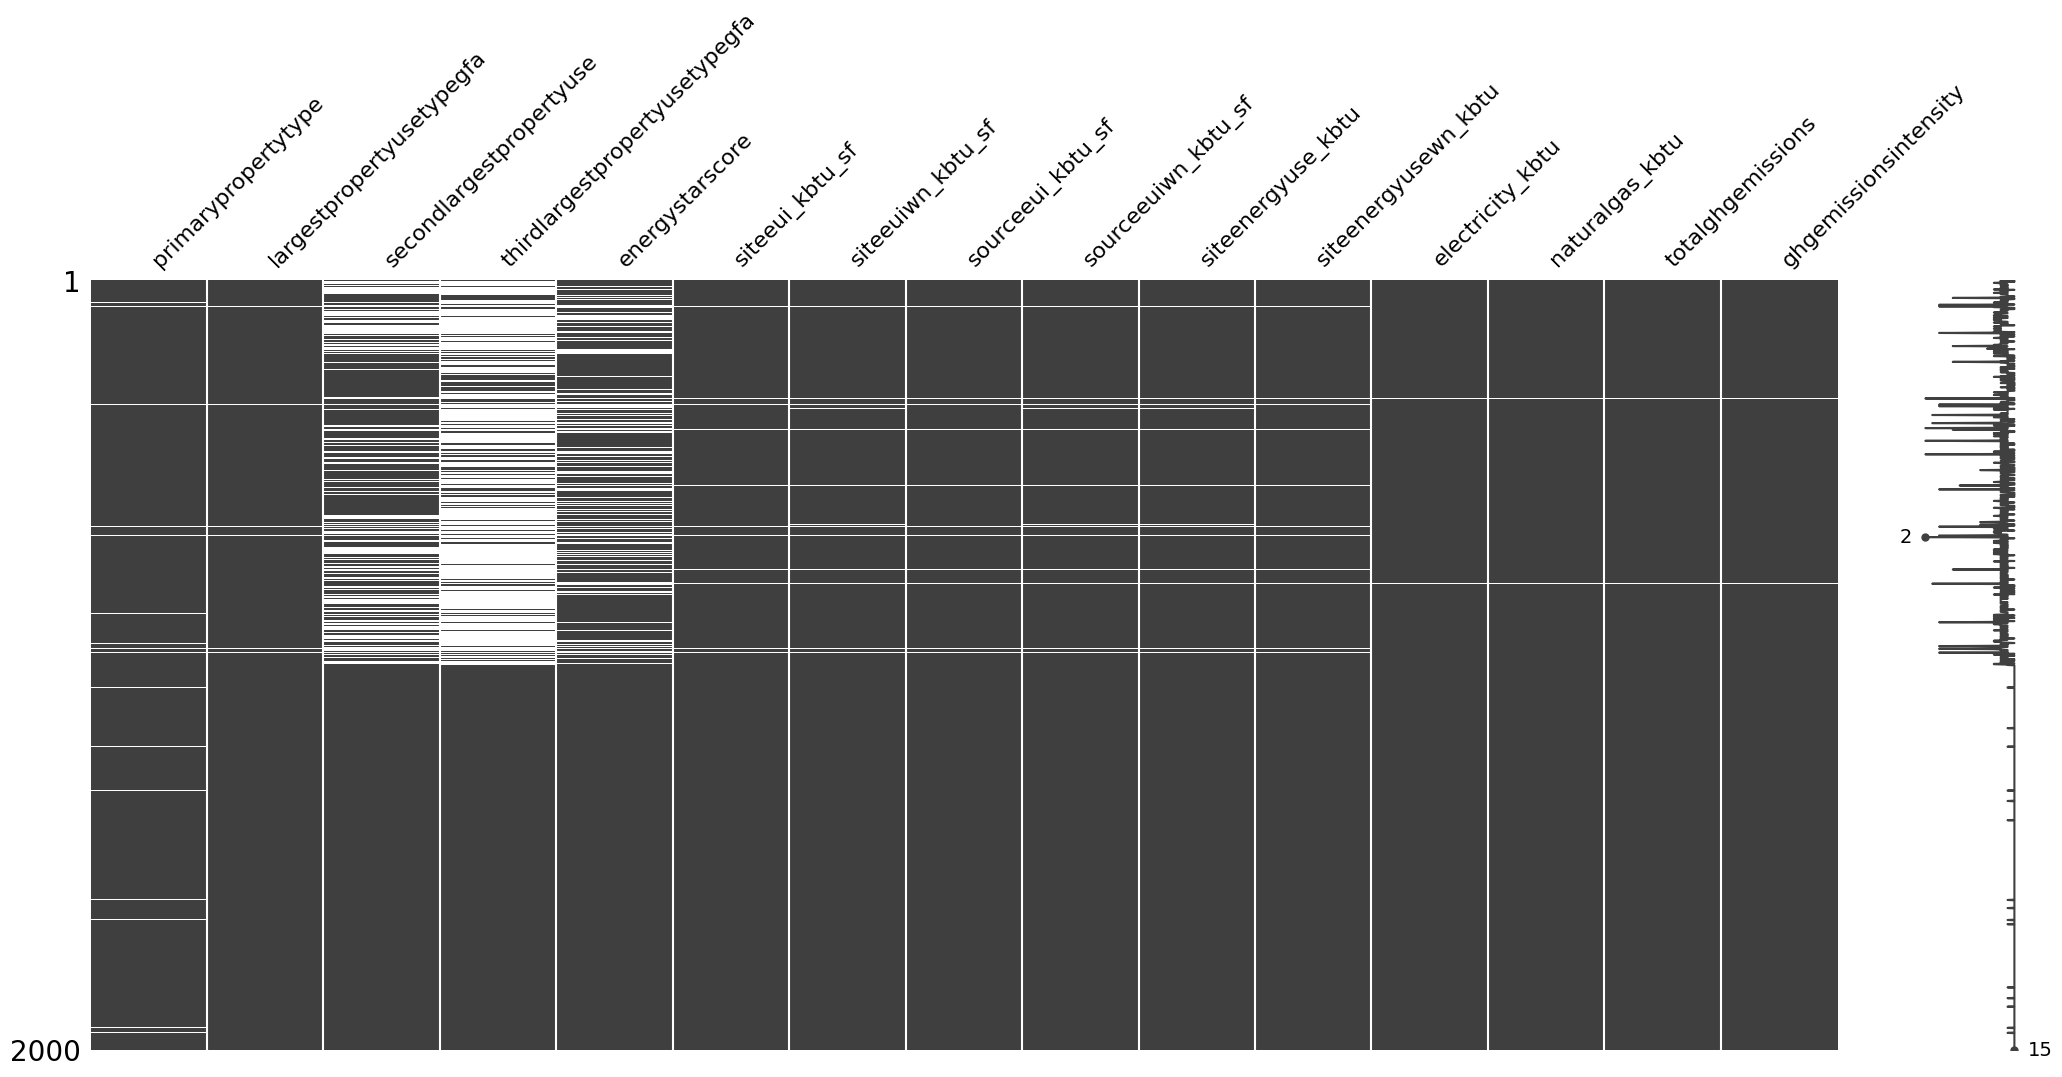

In [18]:
# Create the missingness matrix of missing values for test dataset
df_nulls_test = df_2020_2021_test[df_2020_2021_test.columns[df_2020_2021_test.isna().any()]]
print(df_nulls_test.shape)
msno.matrix(df_nulls_test)

From the two matrices, we can see that our training set has more columns with missing values than our test set. It also appears that there is a similarity in which columns have missing values.

* We can observe that column `thirdlargestpropertyusetypegfa`has > 50% of NaN values, and `secondlargestpropertyuse` has mostly 50% of NaN values. We will drop these columns from both datasets because they are not reliably filled and will not be useful in generating conclusions.

In [19]:
# Drop variables "thirdlargestpropertyusetypegfa" and "secondlargestpropertyuse" since they are too sparsely filled to be useful, or meaningfully imputed
df_2016_2019_train = df_2016_2019_train.drop(columns= ['secondlargestpropertyuse', 'thirdlargestpropertyusetypegfa'])
df_2020_2021_test = df_2020_2021_test.drop(columns=['secondlargestpropertyuse', 'thirdlargestpropertyusetypegfa'])

* Although `energystarscore` is also spasely filled, it directly relates to energy effinciency in the building and so we want to keep it if possible. We will examine this feature more shortly.

* Amoung variables with NaNs only one variable (`primarypropertytype`) is categorical. As it has only 0.33 % of NaN variables, lets replace them with the most occured category.

In [20]:
print("Replace NaNs with the mode. the Mode for training set = ", df_2016_2019_train['primarypropertytype'].mode()[0])
print("Replace NaNs with the mode. the Mode for test set = ", df_2020_2021_test['primarypropertytype'].mode()[0])
df_2016_2019_train['primarypropertytype'] = df_2016_2019_train['primarypropertytype'].fillna(value=df_2016_2019_train['primarypropertytype'].mode()[0])
df_2020_2021_test['primarypropertytype'] = df_2020_2021_test['primarypropertytype'].fillna(value=df_2020_2021_test['primarypropertytype'].mode()[0])

Replace NaNs with the mode. the Mode for training set =  Office
Replace NaNs with the mode. the Mode for test set =  Office


* Now, let's replace all NaNs in variables, where percentage of NaNs < 10% with the mode.

In [21]:
# Any columns still with missing values are saved to df_nulls
df_nulls_train = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
cols_with_nans_train = (df_nulls_train.isnull().sum() * 100 / len(df_nulls_train))[df_nulls_train.isnull().sum() * 100 / len(df_nulls_train) <= 10].index

df_nulls_test = df_2020_2021_test[df_2020_2021_test.columns[df_2020_2021_test.isna().any()]]
cols_with_nans_test = (df_nulls_test.isnull().sum() * 100 / len(df_nulls_test))[df_nulls_test.isnull().sum() * 100 / len(df_nulls_test) <= 10].index

for column in cols_with_nans_train:
  df_2016_2019_train[column] = df_2016_2019_train[column].fillna(value=df_2016_2019_train[column].median())
for column in cols_with_nans_test:
  df_2020_2021_test[column] = df_2020_2021_test[column].fillna(value=df_2020_2021_test[column].median())

* Lets again look at how many columns still have missing values:

In [22]:
df_nulls_train = df_2016_2019_train[df_2016_2019_train.columns[df_2016_2019_train.isna().any()]]
df_nulls_test = df_2020_2021_test[df_2020_2021_test.columns[df_2020_2021_test.isna().any()]]
print("Training columns with Nans: " + str(df_nulls_train.shape[1]))
print(df_nulls_train.columns)
print("Test columns with Nans: " + str(df_nulls_test.shape[1]))
print(df_nulls_test.columns)

Training columns with Nans: 2
Index(['energystarscore', 'steamuse_kbtu'], dtype='object')
Test columns with Nans: 1
Index(['energystarscore'], dtype='object')


* Only two varibles with NaNs are left in our training dataset and one in our test dataset. Let's look at them in more details to undestand the optimal way to replace these values.
### Energystarscore
* Lets start by deciding if the mean or median would be a better aggregate to use.

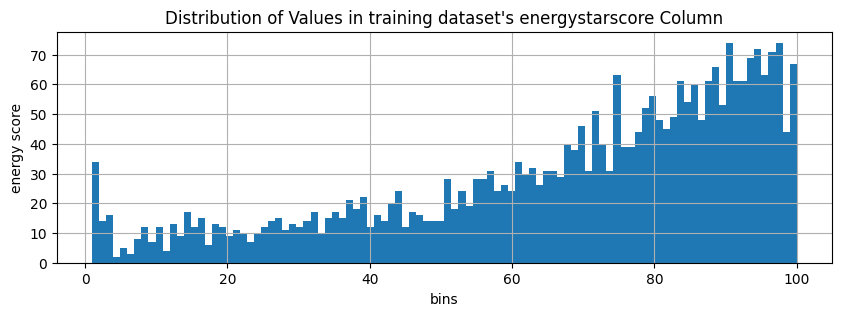

In [23]:
df_nulls_train['energystarscore'].hist(bins=100, figsize=(10, 3))
plt.title("Distribution of Values in training dataset's energystarscore Column")
plt.xlabel("bins")
plt.ylabel("energy score")
plt.show()

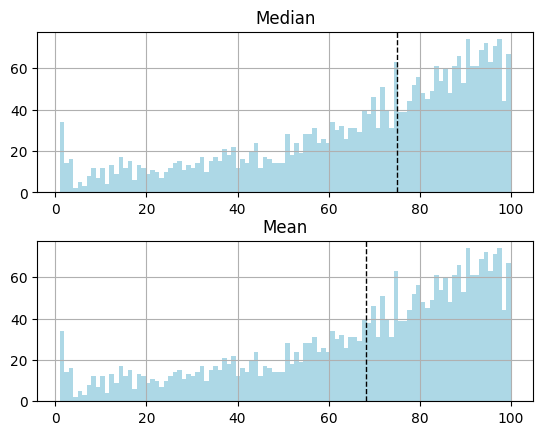

In [24]:
fig, axes = plt.subplots(2)

# Visualze the median and mean on the plot to determine best fitting aggregate
df_nulls_train.hist('energystarscore', bins=100, ax=axes[0], color ='lightblue')
axes[0].axvline(df_nulls_train['energystarscore'].median(), color='k', linestyle='dashed', linewidth=1)
axes[0].set_title("Median")


df_nulls_train.hist('energystarscore', bins=100, ax=axes[1], color ='lightblue')
axes[1].axvline(df_nulls_train['energystarscore'].mean(), color='k', linestyle='dashed', linewidth=1, label='{:5.0f}'.format(df_nulls_train['energystarscore'].mean()))
axes[1].set_title("Mean")
plt.show()

The high skew in the data indicates that the median aggregate would be a better choice for this dataset. Replace NaNs with this value.

In [25]:
# Replace with median
print("Median of training dataset `energystarscore` = ", df_2016_2019_train['energystarscore'].median())
df_2016_2019_train['energystarscore'] = df_2016_2019_train['energystarscore'].fillna(value=df_2016_2019_train['energystarscore'].median())

Median of training dataset `energystarscore` =  75.0


* Lets do the same thing for our test data:

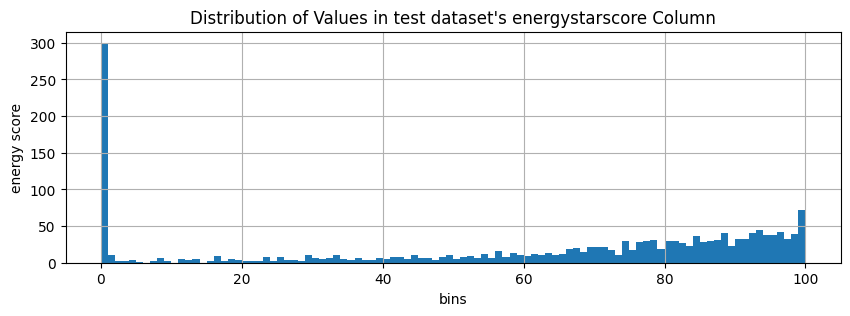

In [26]:
df_nulls_test['energystarscore'].hist(bins=100, figsize=(10, 3))
plt.title("Distribution of Values in test dataset's energystarscore Column")
plt.xlabel("bins")
plt.ylabel("energy score")
plt.show()

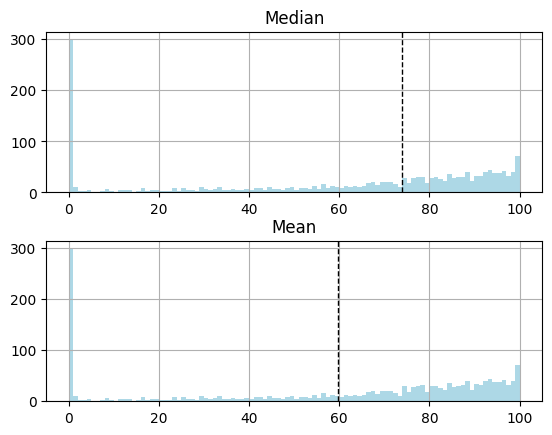

In [27]:
fig, axes = plt.subplots(2)

# Visualze the median and mean on the plot to determine best fitting aggregate
df_nulls_test.hist('energystarscore', bins=100, ax=axes[0], color ='lightblue')
axes[0].axvline(df_nulls_test['energystarscore'].median(), color='k', linestyle='dashed', linewidth=1)
axes[0].set_title("Median")


df_nulls_test.hist('energystarscore', bins=100, ax=axes[1], color ='lightblue')
axes[1].axvline(df_nulls_test['energystarscore'].mean(), color='k', linestyle='dashed', linewidth=1, label='{:5.0f}'.format(df_nulls_test['energystarscore'].mean()))
axes[1].set_title("Mean")
plt.show()

The `energystarscore` column in our test dataset should again be replaced with the median despite the large concentration near 0.

In [28]:
# Replace with median
print("Median of test dataset `energystarscore` = ", df_2020_2021_test['energystarscore'].median())
df_2020_2021_test['energystarscore'] = df_2020_2021_test['energystarscore'].fillna(value=df_2020_2021_test['energystarscore'].median())

Median of test dataset `energystarscore` =  74.0



Verify only one column with Nans remain:


In [29]:
print("Training columns with Nans: " + str(df_nulls_train.shape[1]))
print(df_nulls_train.columns)
print("Test columns with Nans: " + str(df_nulls_test.shape[1]))

Training columns with Nans: 2
Index(['energystarscore', 'steamuse_kbtu'], dtype='object')
Test columns with Nans: 1


### Steamuse_kbtu
* Lets now observe the final column with NaNs: steamuse_kbtu

We can observe from the table below that `steamuse_kbtu` has a problem missing data. There is a large chunk of zero values sectioned together, shown by the missingness matrix for the training dataset. This indicates the data is missing, not at random (MNAR).

In [30]:
pd.value_counts(df_nulls_train.steamuse_kbtu)

<ipython-input-30-b899ce29dba2>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_nulls_train.steamuse_kbtu)


,count
steamuse_kbtu,
0.000000e+00,2740
1.077750e+07,1
5.531580e+05,1
3.700240e+05,1
8.015470e+05,1
...,...
8.308140e+04,1
7.707185e+05,1
3.635556e+06,1


* Lets try dropping the outliers. Start by finding the IQR range:

In [31]:
# calculate IQR for column Height
Q1 = df_nulls_train['steamuse_kbtu'].quantile(0.25)
Q3 = df_nulls_train['steamuse_kbtu'].quantile(0.75)
IQR = Q3 - Q1
# identify outliers
threshold = 1.5
outliers = df_nulls_train[(df_nulls_train['steamuse_kbtu'] < Q1 - threshold * IQR) | (df_nulls_train['steamuse_kbtu'] > Q3 + threshold * IQR)]
outliers

,energystarscore,steamuse_kbtu
0,60.0,2.003882e+06
2,43.0,2.156655e+07
3,56.0,2.214446e+06
7,NaN,2.276286e+06
9,1.0,1.039735e+06
...,...,...
3864,87.0,1.452447e+06
3865,90.0,8.271160e+05
3957,35.0,2.522488e+06
3970,96.0,1.390467e+06


* Drop the identified outliers:

In [32]:
# Drop outliers
df_nulls_train = df_nulls_train.drop(outliers.index)
# Describe effect
df_nulls_train.describe()

,energystarscore,steamuse_kbtu
count,2646.000000,2740.0
mean,68.177627,0.0
std,26.335443,0.0
min,1.000000,0.0
25%,53.000000,0.0
50%,75.000000,0.0
75%,89.000000,0.0
max,100.000000,0.0


* We can observe that 2740 of values in `steamuse_kbtu` have missing values, since any building with recorded energy usage has an associated steamuse value. Only 343 observations out of 3083 have meaningful values. This clumn does not have enough data to replace NaNs very well. It is also a factor in the ghgemmissions column. We should drop this column in both datasets since it is redundant, and cannot reasonable be filled.

In [33]:
# Drop "steamuse_kbtu" variable
df_2016_2019_train = df_2016_2019_train.drop(columns = ['steamuse_kbtu'])
df_2020_2021_test = df_2020_2021_test.drop(columns = ['steamuse_kbtu'])

In [34]:
#Check if any Nans left
df_nulls_train = df_2016_2019_train.isna().any()
print("training columns with Nan values remaining: " + str(df_nulls_train.sum()))
df_nulls_test = df_2020_2021_test.isna().any()
print("test columns with Nan values remaining: " + str(df_nulls_test.sum()))

training columns with Nan values remaining: 0
test columns with Nan values remaining: 0


## Handling Categorical Variables
We are going to continue preparing our dataset by examining our qualitative variables.



In [35]:
#Output all categorical variables
df_categorical = df_2016_2019_train.select_dtypes(include=['object'])
df_categorical

,buildingtype,primarypropertytype,compliancestatus
0,NonResidential,Hotel,Compliant
1,NonResidential,Hotel,Compliant
2,NonResidential,Hotel,Compliant
3,NonResidential,Hotel,Compliant
4,NonResidential,Hotel,Compliant
...,...,...,...
3995,NonResidential,Mixed Use Property,Compliant
3996,Multifamily MR (5-9),Multifamily Housing,Compliant
3997,NonResidential,Other,Compliant
3998,Multifamily MR (5-9),Multifamily Housing,Compliant


Lets look at each of these varibles individually.
### Buildingtype

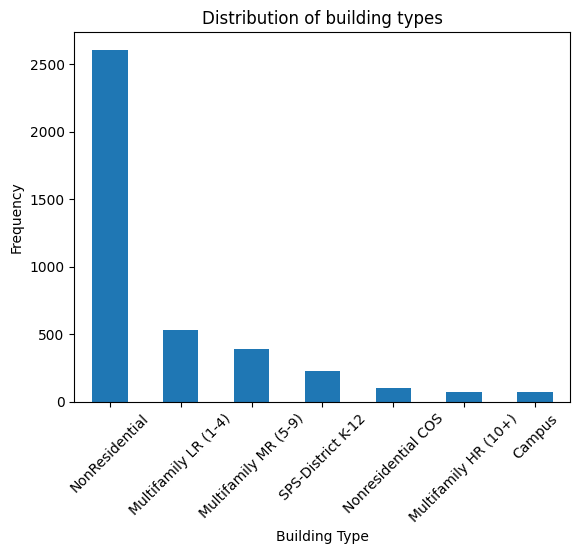

In [36]:
df_categorical['buildingtype'].value_counts().plot(kind='bar')
plt.title("Distribution of building types")
plt.xlabel("Building Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

To reduce the complexity of this column, we are going to map categories to new ones we define below:
* Combine "NonResidential", "Nonresidential COS" in "Nonresidential"

* Combine "Multifamily LR (1-4)", "Multifamily MR (5-9)", "Multifamily HR (10+)" in "Multifamily"

* Combine "SPS-District K-12" and "Campus" in "Others"

In [37]:
# This function does the work of combining variables so we don't have to do it twice.
def combine_values_building_id(df):
  df.loc[(df['buildingtype'] == 'NonResidential'), 'buildingtype'] = 'Nonresidential'
  df.loc[(df['buildingtype'] == 'Nonresidential COS'),  'buildingtype'] = 'Nonresidential'

  df.loc[(df['buildingtype'] == 'Multifamily LR (1-4)'), 'buildingtype'] = 'Multifamily'
  df.loc[(df['buildingtype'] == 'Multifamily MR (5-9)'),  'buildingtype'] = 'Multifamily'
  df.loc[(df['buildingtype'] == 'Multifamily HR (10+)'), 'buildingtype'] = 'Multifamily'

  df.loc[(df['buildingtype'] == 'SPS-District K-12'), 'buildingtype'] = 'Other'
  df.loc[(df['buildingtype'] == 'Campus'), 'buildingtype'] = 'Other'

# Combine values of variables
combine_values_building_id(df_2016_2019_train)
combine_values_building_id(df_2020_2021_test)
print("Training set:")
print("Updated number of unique values in `buildingtype`:", df_2016_2019_train.buildingtype.nunique())
print(pd.value_counts(df_2016_2019_train.buildingtype))
print(pd.value_counts(df_2020_2021_test.buildingtype))

Training set:
Updated number of unique values in `buildingtype`: 3
buildingtype
Nonresidential    2709
Multifamily        992
Other              299
Name: count, dtype: int64
buildingtype
Nonresidential    1327
Multifamily        517
Other              156
Name: count, dtype: int64


<ipython-input-37-77058569d12d>:18: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df_2016_2019_train.buildingtype))
<ipython-input-37-77058569d12d>:19: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df_2020_2021_test.buildingtype))


To change these categorical variables into binary variables, we will use dummy variables. Below we add 3 columns that represent Multifamily, Nonresidentail, or Other buildingtypes.

In [38]:
# Create dummy variables insted of "buildingtype" variable
dummy = pd.get_dummies(df_2016_2019_train['buildingtype'])
df_2016_2019_train = pd.concat([df_2016_2019_train, dummy], axis = 1)
df_2016_2019_train = df_2016_2019_train.drop(columns = ['buildingtype'])
df_2016_2019_train[['Multifamily', 'Nonresidential', 'Other']]

dummy = pd.get_dummies(df_2020_2021_test['buildingtype'])
df_2020_2021_test = pd.concat([df_2020_2021_test, dummy], axis = 1)
df_2020_2021_test = df_2020_2021_test.drop(columns = ['buildingtype'])
df_2020_2021_test[['Multifamily', 'Nonresidential', 'Other']]

,Multifamily,Nonresidential,Other
0,False,True,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False
...,...,...,...
1995,False,True,False
1996,False,True,False
1997,True,False,False
1998,False,True,False


### Primarypropertytype
Lets look at our next categorical variable.


In [39]:
print("Number of unique values in primarypropertytype column:", df_categorical.primarypropertytype.nunique())
pd.value_counts(df_2020_2021_test.primarypropertytype)

Number of unique values in primarypropertytype column: 61


<ipython-input-39-bc923ad51301>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_2020_2021_test.primarypropertytype)


,count
primarypropertytype,
Office,531
Multifamily LR (1-4),271
Multifamily MR (5-9),202
K-12 School,134
Hotel,113
Mixed Use Property,109
Non-Refrigerated Warehouse,101
Retail Store,56
Distribution Center,51


* This column encodes information about property type. Since we already catagorized this data in the dummy columns previously, we don't need this column, so we drop it:

In [40]:
# Drop "primarypropertytype" variable
df_2016_2019_train = df_2016_2019_train.drop(columns = ['primarypropertytype'])
df_2020_2021_test = df_2020_2021_test.drop(columns = ['primarypropertytype'])

### Compliancestatus
Lets look at our final categorical column by examining its unique values:


In [41]:
print("Number of unique values in `compliancestatus`:", df_categorical.compliancestatus.nunique())
pd.value_counts(df_categorical.compliancestatus)

Number of unique values in `compliancestatus`: 7


<ipython-input-41-1e95258114ee>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_categorical.compliancestatus)


,count
compliancestatus,
Compliant,3702
Not Compliant,180
Error - Correct Default Data,51
Account Requires Verification,43
Missing Data,13
Non-Compliant,10
Connection Error,1


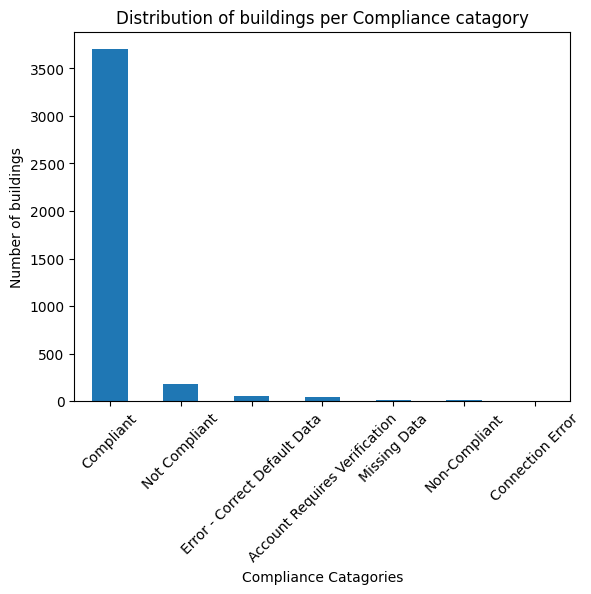

In [42]:
df_categorical['compliancestatus'].value_counts().plot(kind='bar')
plt.ylabel("Number of buildings")
plt.xlabel("Compliance Catagories")
plt.title("Distribution of buildings per Compliance catagory")
plt.xticks(rotation=45)
plt.show()

We can see that most obsevations in `compliancestatus` have a "Compliant" value. Let's create a boolean variable to replace our catagorical one.
* We will have 1 = a Compliant value,
* We will have 0 = otherwise.

In [43]:
# Make "compliancestatus" a boolean variable
df_2016_2019_train.loc[(df_2016_2019_train['compliancestatus'] == 'Compliant'), 'compliancestatus_bool'] = 1
df_2016_2019_train.loc[~(df_2016_2019_train['compliancestatus'] == 'Compliant'),  'compliancestatus_bool'] = 0
df_2016_2019_train = df_2016_2019_train.drop(columns = ['compliancestatus'])
df_2020_2021_test.loc[(df_2020_2021_test['compliancestatus'] == 'Compliant'), 'compliancestatus_bool'] = 1
df_2020_2021_test.loc[~(df_2020_2021_test['compliancestatus'] == 'Compliant'),  'compliancestatus_bool'] = 0
df_2020_2021_test = df_2020_2021_test.drop(columns = ['compliancestatus'])

In [44]:
df_2016_2019_train.info

<bound method DataFrame.info of       datayear  zipcode  councildistrictcode  latitude  longitude  yearbuilt  \
0         2016  98101.0                  7.0  47.61220 -122.33799       1927   
1         2016  98101.0                  7.0  47.61317 -122.33393       1996   
2         2016  98101.0                  7.0  47.61393 -122.33810       1969   
3         2016  98101.0                  7.0  47.61412 -122.33664       1926   
4         2016  98121.0                  7.0  47.61375 -122.34047       1980   
...        ...      ...                  ...       ...        ...        ...   
3995      2019  98125.0                  5.0  47.72178 -122.29498       1979   
3996      2019  98125.0                  1.0  47.72235 -122.29584       2008   
3997      2019  98125.0                  5.0  47.72032 -122.29507       1949   
3998      2019  98125.0                  5.0  47.72082 -122.29195       1971   
3999      2019  98125.0                  1.0  47.71951 -122.29477       2001   

      numberoffloors  propertygfatotal  propertygfaparking  \
0                 12             88434                 0.0   
1                 11            103566             15064.0   
2                 41            956110            196718.0   
3                 10             61320                 0.0   
4                 18            175580             62000.0   
...              ...               ...                 ...   
3995               1             39350                 0.0   
3996               6            193691             34414.0   
3997               1             22405                 0.0   
3998               7             86283                 0.0   
3999               6             57775             11286.0   

      propertygfabuilding_s  ...  electricity_kwh  electricity_kbtu  \
0                   88434.0  ...     1.156514e+06         3946027.0   
1                   88502.0  ...     9.504252e+05         3242851.0   
2                  759392.0  ...     1.451544e+07        49526664.0   
3                   61320.0  ...     8.115253e+05         2768924.0   
4                  113580.0  ...     1.573449e+06         5368607.0   
...                     ...  ...              ...               ...   
3995                39350.0  ...     8.497800e+04          289946.0   
3996               159277.0  ...     1.205828e+06         4114285.0   
3997                22405.0  ...     3.354470e+05         1144544.0   
3998                86283.0  ...     8.751200e+05         2985909.0   
3999                46489.0  ...     6.478000e+05         2210295.0   

      naturalgas_therms  naturalgas_kbtu  totalghgemissions  \
0           12764.52930        1276453.0             249.98   
1           51450.81641        5145082.0             295.86   
2           14938.00000        1493800.0            2089.28   
3           18112.13086        1811213.0             286.43   
4           88039.98438        8803998.0             505.01   
...                 ...              ...                ...   
3995        10431.00000        1043058.0              57.20   
3996        20229.00000        2022851.0             132.80   
3997        19381.00000        1938090.0             110.00   
3998         7336.00000         733604.0              57.40   
3999            0.00000              0.0              13.60   

      ghgemissionsintensity  Multifamily  Nonresidential  Other  \
0                      2.83        False            True  False   
1                      2.86        False            True  False   
2                      2.19        False            True  False   
3                      4.67        False            True  False   
4                      2.88        False            True  False   
...                     ...          ...             ...    ...   
3995                   1.50        False            True  False   
3996                   0.80         True           False  False   
3997                   4.90        False         

# **Exploratory Data Analysis**
We now begin to examine our target variable, and try to identify links between it and our features.

## Identifying The Target Variable
Now that we have done some initial data preperation, lets evaluate our target variable, and identify any issues we may have:

* The target variable in the datasets is `SiteEnergyUse(kBtu)` <br>
The target variable(s) for these datasets were identified by the dataset creators. There were several choices we could have picked, and we describe them here:
There are several options we could have choosen for the target variable:
* `SiteEnergyUse(kBtu)`(`"siteenergyuse_kbtu"`) - <br> The annual amount of energy consumed by the property from all sources of energy.

* `SiteEnergyUseWN(kBtu)`(`"siteenergyusewn_kbtu"`) - <br>The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions.

In order to avoid overfitting, we should drop the `SiteEnergyUseWN(kBtu)` variable.

In [45]:
# create target variable
target_variable = 'siteenergyuse_kbtu'

#Drop "siteenergyusewn_kbtu" variable
df_2016_2019_train = df_2016_2019_train.drop(columns = ['siteenergyusewn_kbtu'])
df_2020_2021_test = df_2020_2021_test.drop(columns = ['siteenergyusewn_kbtu'])

* Lets look at the distribution of our values for our target:

In [46]:
print(df_2016_2019_train['siteenergyuse_kbtu'].describe())

count    4.000000e+03
mean     1.179746e+07
std      9.995955e+07
min      0.000000e+00
25%      1.759337e+06
50%      3.954126e+06
75%      9.177614e+06
max      6.063691e+09
Name: siteenergyuse_kbtu, dtype: float64


* It appears that our target variable has a skew, with its max value being well outside the IQR range. Furthermore, the mean is also above the 75% mark. This further indicates a high skew.
* Lets visualize its distribution:

Text(0.5, 9.444444444444438, 'Energy Usage')

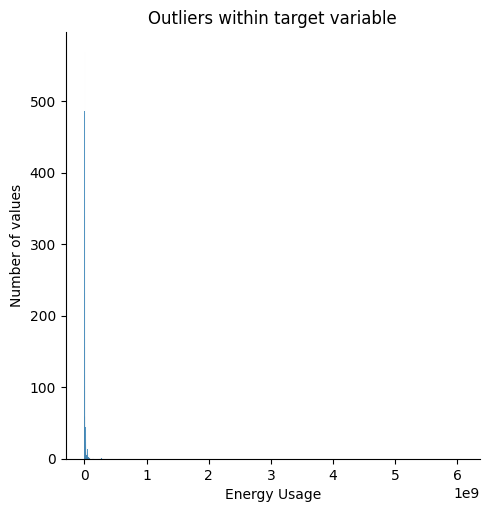

In [47]:
sns.displot(df_2016_2019_train, x = 'siteenergyuse_kbtu')
plt.title("Outliers within target variable")
plt.ylabel("Number of values")
plt.xlabel("Energy Usage")

It appears that we may have outliers in our target that are skewing results. Lets figure out how to handle these:
### Handling Outliers in Target Variable

* First, we want to separate our target variable from the rest of the dataset:

In [48]:
df_target = df_2016_2019_train[[target_variable]]
df_target

,siteenergyuse_kbtu
0,7226362.5
1,8387933.0
2,72587024.0
3,6794584.0
4,14172606.0
...,...
3995,1328430.0
3996,6152096.0
3997,3076972.0
3998,3768958.0


* Next, we want to calculate the Inter-Quartile range for the target:

In [49]:
# calculate IQR
Q1 = df_target['siteenergyuse_kbtu'].quantile(0.25)
Q3 = df_target['siteenergyuse_kbtu'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 2
outliers = df_target[(df_target['siteenergyuse_kbtu'] < Q1 - threshold * IQR) | (df_target['siteenergyuse_kbtu'] > Q3 + threshold * IQR)]
outliers

,siteenergyuse_kbtu
2,72587024.0
11,26941110.0
17,33556756.0
20,44984468.0
21,47859812.0
...,...
3566,89917528.0
3604,275296608.0
3796,26808334.0
3797,36729196.0


The number of outliers is 350. We decide to drop them from the training dataset for following reasons:
1. We will still have 3650 entries in our dataset after dropping them.
2. We don't wish to add bias to our model by using an aggregate.
3. We previously identified a heavy skew due to the outliers, so dropping them will improve our future model.

In [50]:
df_2016_2019_train = df_2016_2019_train.drop(outliers.index)
df_2016_2019_train = df_2016_2019_train.reset_index(drop=True)
df_2016_2019_train
# df_2020_2021_test = df_2020_2021_test.drop(outliers.index)
# df_2020_2021_test = df_2020_2021_test.reset_index(drop=True)

,datayear,zipcode,councildistrictcode,latitude,longitude,yearbuilt,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,...,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity,Multifamily,Nonresidential,Other,compliancestatus_bool
0,2016,98101.0,7.0,47.61220,-122.33799,1927,12,88434,0.0,88434.0,...,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83,False,True,False,1.0
1,2016,98101.0,7.0,47.61317,-122.33393,1996,11,103566,15064.0,88502.0,...,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86,False,True,False,1.0
2,2016,98101.0,7.0,47.61412,-122.33664,1926,10,61320,0.0,61320.0,...,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,4.67,False,True,False,1.0
3,2016,98121.0,7.0,47.61375,-122.34047,1980,18,175580,62000.0,113580.0,...,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,2.88,False,True,False,1.0
4,2016,98101.0,7.0,47.61623,-122.33657,1999,2,97288,37198.0,60090.0,...,2.160444e+06,7371434.0,47151.81641,4715182.0,301.81,3.10,False,True,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,2019,98125.0,5.0,47.72178,-122.29498,1979,1,39350,0.0,39350.0,...,8.497800e+04,289946.0,10431.00000,1043058.0,57.20,1.50,False,True,False,1.0
3646,2019,98125.0,1.0,47.72235,-122.29584,2008,6,193691,34414.0,159277.0,...,1.205828e+06,4114285.0,20229.00000,2022851.0,132.80,0.80,True,False,False,1.0
3647,2019,98125.0,5.0,47.72032,-122.29507,1949,1,22405,0.0,22405.0,...,3.354470e+05,1144544.0,19381.00000,1938090.0,110.00,4.90,False,True,False,1.0
3648,2019,98125.0,5.0,47.72082,-122.29195,1971,7,86283,0.0,86283.0,...,8.751200e+05,2985909.0,7336.00000,733604.0,57.40,0.70,True,False,False,1.0


The new distribution of target variable siteenergyuse_kbtu:

* We can see that it is right skewed:

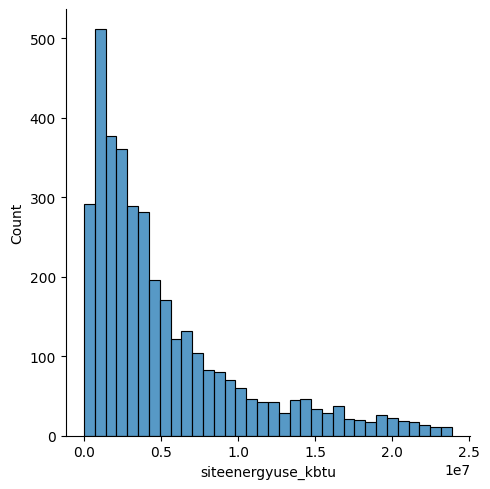

In [51]:
sns.displot(df_2016_2019_train, x = 'siteenergyuse_kbtu')

To try and gain some understanding on how energy usage in the city of seattle changed during Covid, we will examine the mean energy usage of buildings in both the training and test datasets.
* The functions below are used to calculate differences between experienced means, and to visualize the means against one another.

In [52]:
def getMeansOfBuildingType(df):
  df_multi = df[df['Multifamily'] == 1]
  df_other = df[df['Other'] == 1]
  df_nonres = df[df['Nonresidential'] == 1]
  # Save their means in an array
  return [df_multi['siteenergyuse_kbtu'].mean(), df_other['siteenergyuse_kbtu'].mean(), df_nonres['siteenergyuse_kbtu'].mean()]

# This function prints the mean values of building columns of dataset df
max_usage = 0
def plotMeanOfBuildingType(df, df_name, max_usage):
    # Split data set by building type
    df_multi = df[df['Multifamily'] == 1]
    df_other = df[df['Other'] == 1]
    df_nonres = df[df['Nonresidential'] == 1]
    max_val = max(df_multi['siteenergyuse_kbtu'].max(), df_other['siteenergyuse_kbtu'].max(), df_nonres['siteenergyuse_kbtu'].max())
    if 0 == max_usage:
      max_usage = max_val
    # Save their means in an array
    plt_means = [df_multi['siteenergyuse_kbtu'].mean(), df_other['siteenergyuse_kbtu'].mean(), df_nonres['siteenergyuse_kbtu'].mean()]
    plt_columns = ['Multifamily', 'Other', 'NonResidential']

    # Plot the values
    plt.figure(figsize=(10, 5))
    bars = plt.bar(plt_columns, plt_means, color='blue', alpha=0.7)

    # Add labels on each bar
    for bar, mean_value in zip(bars, plt_means):
        yval = round(mean_value, 2)
        plt.text(bar.get_x() + bar.get_width() / 2, yval, str(yval), ha='center', va='bottom')

    plt.xlabel('Building type')
    plt.ylabel('Mean Values')
    plt.ylim(bottom = 0, top = max_usage)
    plt.title("Mean Building Type Energy Usage in " + df_name + " Dataset")
    plt.show()

Lets try to get an understanding of our energy usage by looking at usage based on building type:

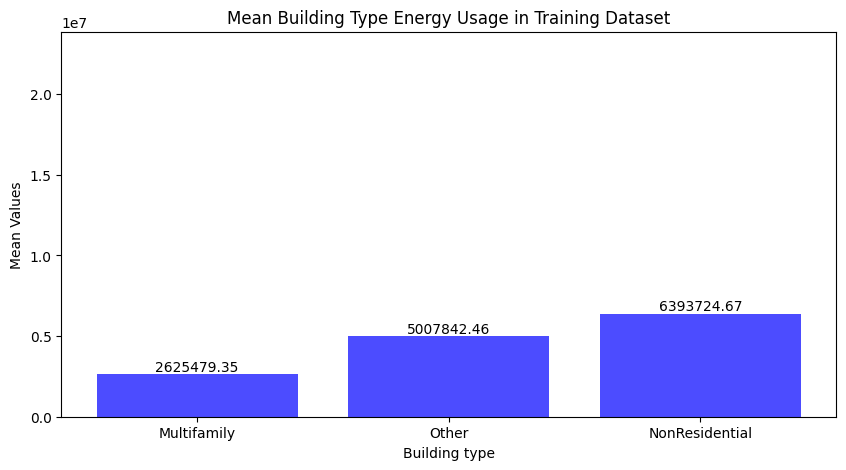

In [53]:
plotMeanOfBuildingType(df_2016_2019_train, 'Training', max_usage)

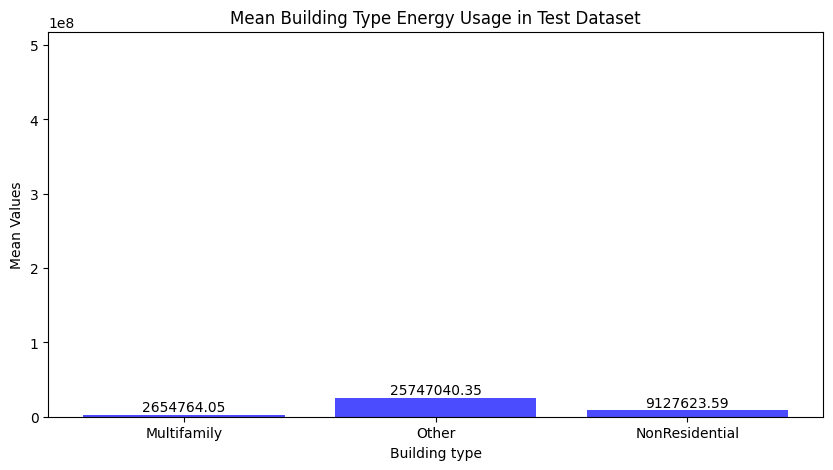

In [54]:
plotMeanOfBuildingType(df_2020_2021_test, 'Test', max_usage)

The size of the energy usage makes it hard to compare the two graphs. Lets find the numerical difference between them:

In [55]:
# Calculate and display the difference between associated means:
training_mean = getMeansOfBuildingType(df_2016_2019_train)
test_mean = getMeansOfBuildingType(df_2020_2021_test)
building_types = ['Multifamily', 'Other', 'NonResidential']
diff_of_means_by_building_type = []
for i in range(len(test_mean)):
  diff_of_means_by_building_type.append(test_mean[i]-training_mean[i])
  print(building_types[i] + " has an increase of " + str(diff_of_means_by_building_type[i]) + \
        " kbtu or an increase of " + str(10*(diff_of_means_by_building_type[i]/training_mean[i])) + " percent.")

Multifamily has an increase of 29284.70604004059 kbtu or an increase of 0.11154041665201508 percent.
Other has an increase of 20739197.88810332 kbtu or an increase of 41.41343909135208 percent.
NonResidential has an increase of 2733898.9200095534 kbtu or an increase of 4.275909677772589 percent.


These differences show that there was a growth in energy usage across Seattle for all types of large buildings.
* Multifamily buildings had an increase of 0.1 percent.
* Other buildings had an increase of 41.4 percent.
* Nonresidentail buildings had an increase of 4.27 percent.

**1. Heatmap**

 We want to check for correlations between features, as they would show us whether we have any multicollinearity issues:


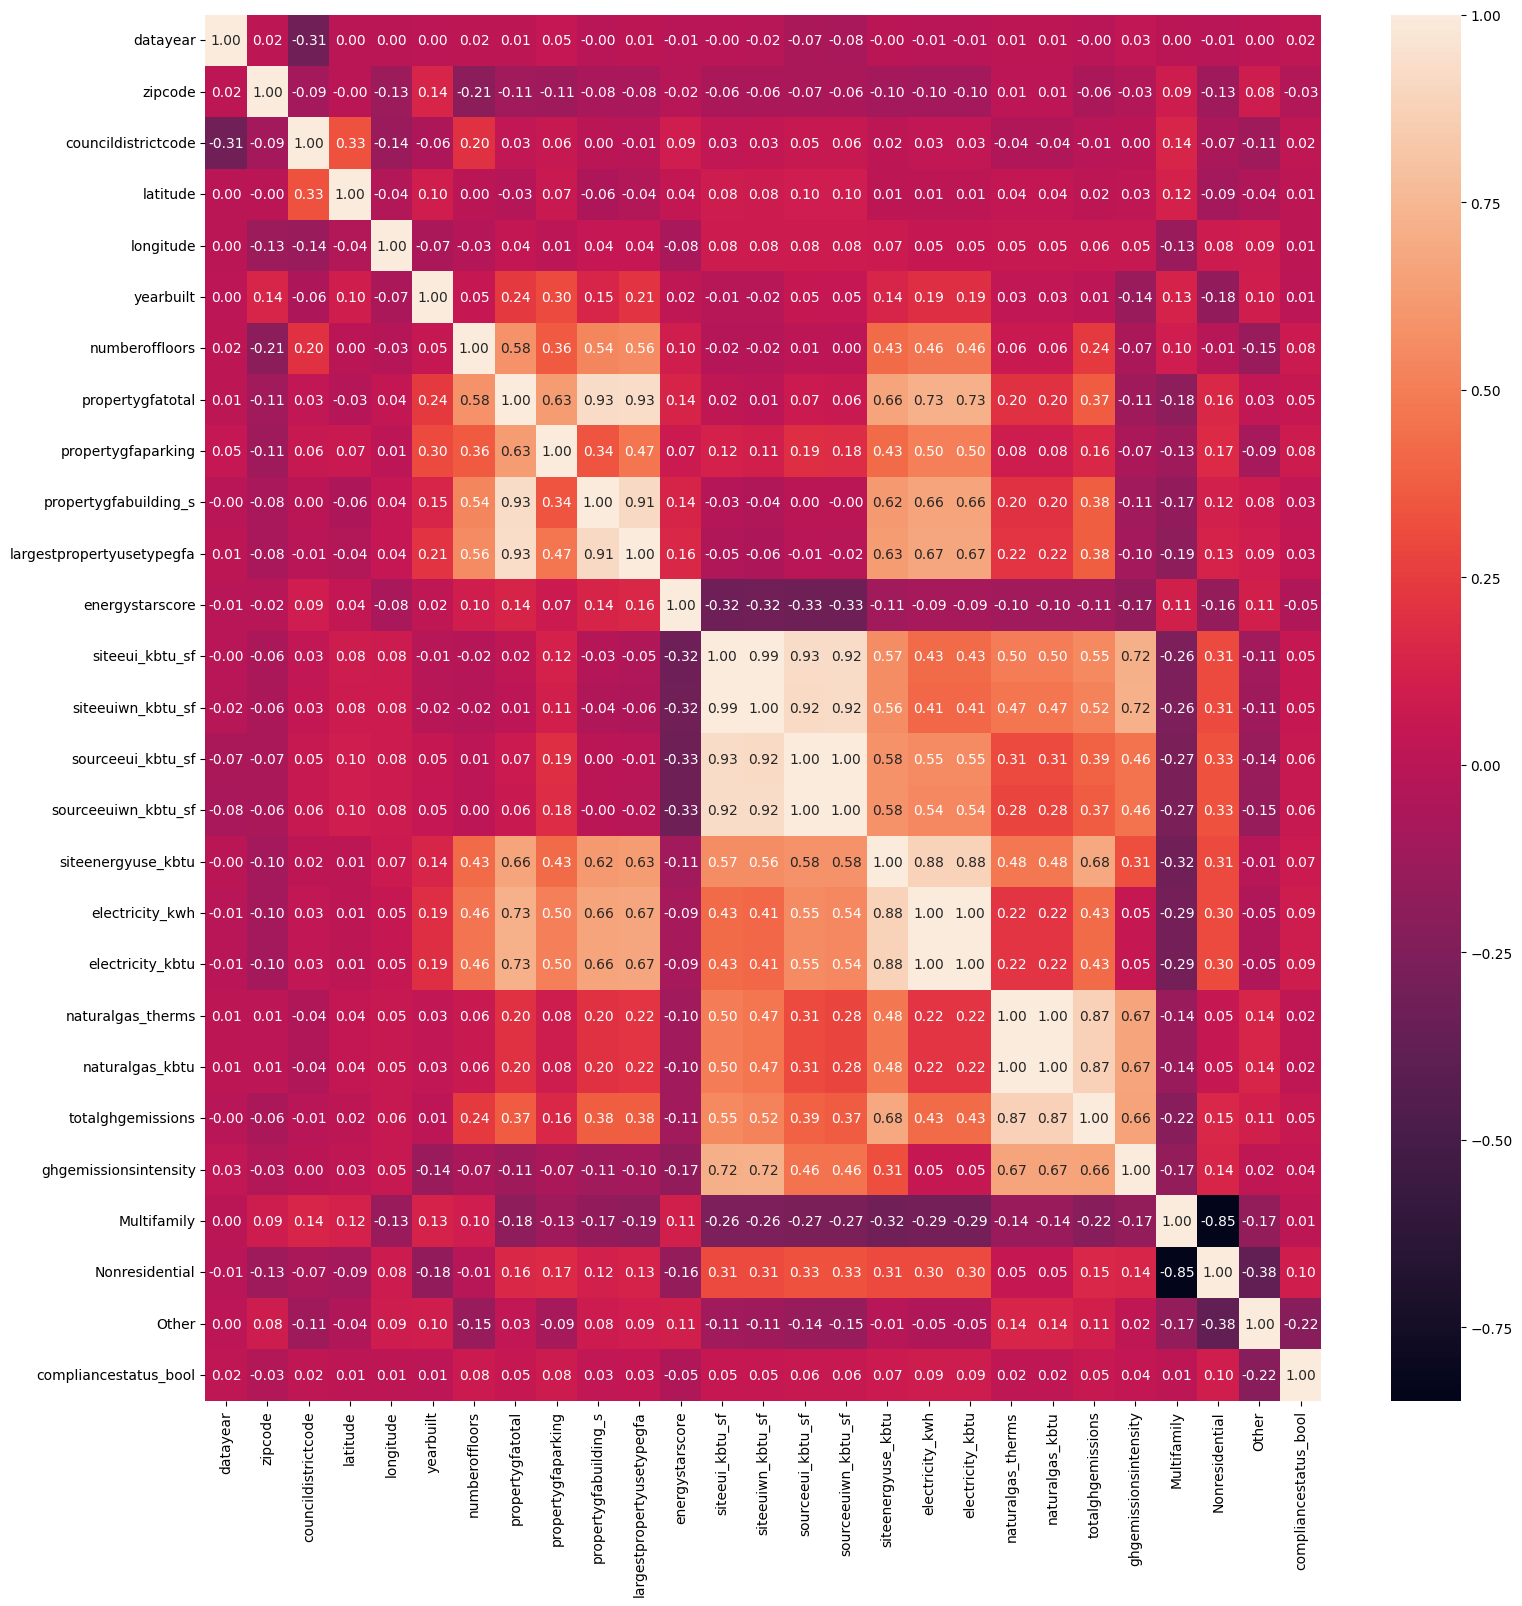

In [56]:
plt.figure(figsize=(18, 18))
ax = sns.heatmap(df_2016_2019_train.corr(), annot=True, fmt=f'.{2}f')

The heatmap output notified us of 4 issues in our data:
* `Electricity_kwh` and `electricity_kbtu`
* `naturalgas_therms` and `naturalgas_kbtu`
* `siteeui_kbtu_sf` and `siteeuiwn_kbtu_sf`
* `sourceeui_kbtu_sf` and `sourceeuiwn_kbtu_sf`

Each of these four connections has a redundant value that is a conversion from one unit to another, which causes the correlation. <br>

* `Electricity_kwh` and `naturalgas_therms` will be removed so that we can keep kbtu as our unit of measurement for energy.<br>
* `siteeuiwn_kbtu_sf` and `sourceeuiwn_kbtu_sf` will be removed since we are using the non weather-normalized as our target variable.

In [57]:
col_to_drop = ['electricity_kwh', 'naturalgas_therms', 'siteeuiwn_kbtu_sf', 'sourceeuiwn_kbtu_sf']
df_2016_2019_train = df_2016_2019_train.drop(columns = col_to_drop)
df_2020_2021_test = df_2020_2021_test.drop(columns = col_to_drop)
print(df_2016_2019_train.columns)

Index(['datayear', 'zipcode', 'councildistrictcode', 'latitude', 'longitude',
       'yearbuilt', 'numberoffloors', 'propertygfatotal', 'propertygfaparking',
       'propertygfabuilding_s', 'largestpropertyusetypegfa', 'energystarscore',
       'siteeui_kbtu_sf', 'sourceeui_kbtu_sf', 'siteenergyuse_kbtu',
       'electricity_kbtu', 'naturalgas_kbtu', 'totalghgemissions',
       'ghgemissionsintensity', 'Multifamily', 'Nonresidential', 'Other',
       'compliancestatus_bool'],
      dtype='object')


**2. Let's look at the distribution of all of the features by ploting them.**

In [58]:

df_2016_2019_train

,datayear,zipcode,councildistrictcode,latitude,longitude,yearbuilt,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,...,sourceeui_kbtu_sf,siteenergyuse_kbtu,electricity_kbtu,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity,Multifamily,Nonresidential,Other,compliancestatus_bool
0,2016,98101.0,7.0,47.61220,-122.33799,1927,12,88434,0.0,88434.0,...,182.500000,7226362.5,3946027.0,1276453.0,249.98,2.83,False,True,False,1.0
1,2016,98101.0,7.0,47.61317,-122.33393,1996,11,103566,15064.0,88502.0,...,176.100006,8387933.0,3242851.0,5145082.0,295.86,2.86,False,True,False,1.0
2,2016,98101.0,7.0,47.61412,-122.33664,1926,10,61320,0.0,61320.0,...,216.199997,6794584.0,2768924.0,1811213.0,286.43,4.67,False,True,False,1.0
3,2016,98121.0,7.0,47.61375,-122.34047,1980,18,175580,62000.0,113580.0,...,211.399994,14172606.0,5368607.0,8803998.0,505.01,2.88,False,True,False,1.0
4,2016,98101.0,7.0,47.61623,-122.33657,1999,2,97288,37198.0,60090.0,...,316.299988,12086616.0,7371434.0,4715182.0,301.81,3.10,False,True,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,2019,98125.0,5.0,47.72178,-122.29498,1979,1,39350,0.0,39350.0,...,46.299999,1328430.0,289946.0,1043058.0,57.20,1.50,False,True,False,1.0
3646,2019,98125.0,1.0,47.72235,-122.29584,2008,6,193691,34414.0,159277.0,...,70.400002,6152096.0,4114285.0,2022851.0,132.80,0.80,True,False,False,1.0
3647,2019,98125.0,5.0,47.72032,-122.29507,1949,1,22405,0.0,22405.0,...,243.699997,3076972.0,1144544.0,1938090.0,110.00,4.90,False,True,False,1.0
3648,2019,98125.0,5.0,47.72082,-122.29195,1971,7,86283,0.0,86283.0,...,105.800003,3768958.0,2985909.0,733604.0,57.40,0.70,True,False,False,1.0


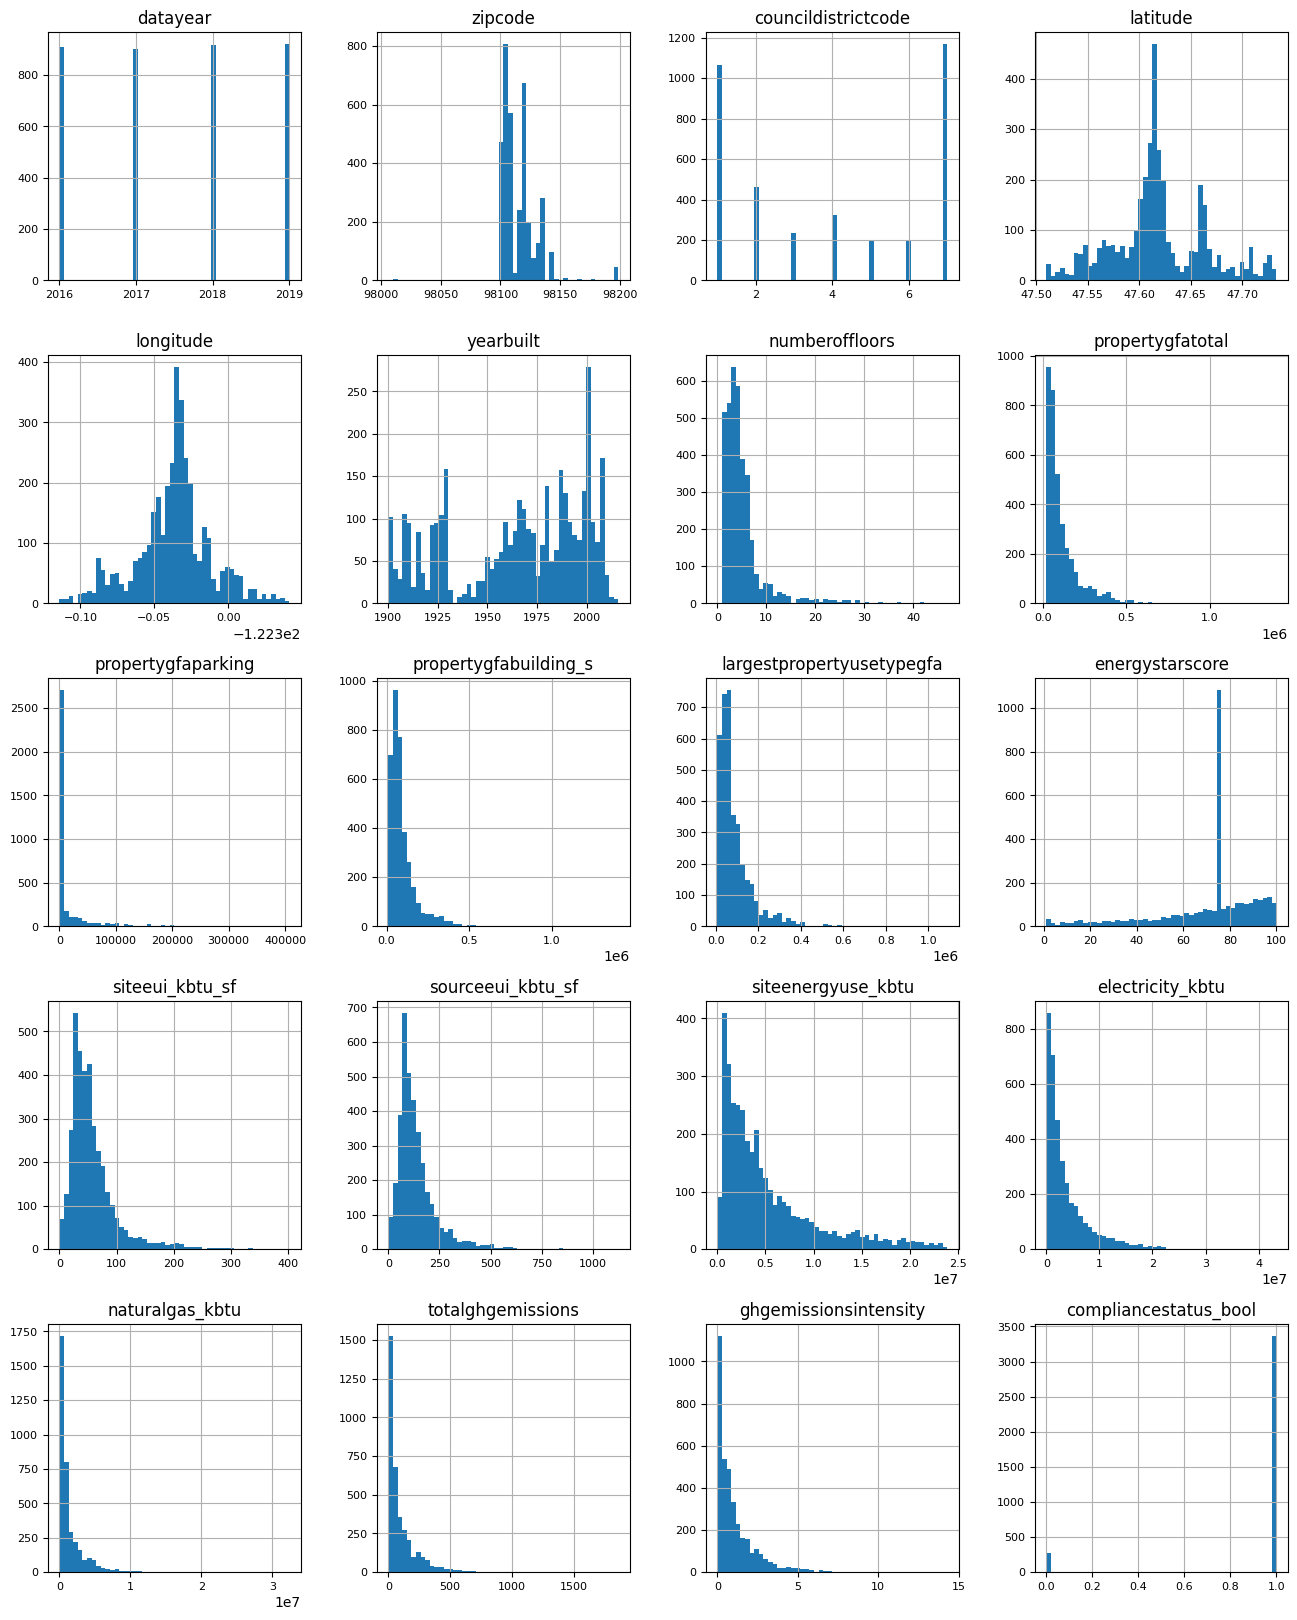

In [59]:
df_2016_2019_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

**3. Outliers(Correlation is affected by outliers)**

So we could proceed as follow:

3.1. Plot the numerical features and see which ones have very few or explainable outliers

3.2. Remove the outliers from these features and see which one can have a good correlation without their outliers

### Drop Features related to target variable
Several of the features are directly calculated from the target variable. To ensure these values do not influence our model, we drop them here.

In [60]:
#Drop all variables related to energy consumption
df_2016_2019_train = df_2016_2019_train.drop(columns = ['energystarscore', 'siteeui_kbtu_sf',  'sourceeui_kbtu_sf', 'electricity_kbtu',
                                                        'naturalgas_kbtu', 'totalghgemissions', 'ghgemissionsintensity'])
['electricity_kwh', 'naturalgas_therms', 'siteeuiwn_kbtu_sf', 'sourceeuiwn_kbtu_sf']
#Drop these variables for test dataset too
df_2020_2021_test = df_2020_2021_test.drop(columns = ['energystarscore', 'siteeui_kbtu_sf',  'sourceeui_kbtu_sf', 'electricity_kbtu',
                                                        'naturalgas_kbtu', 'totalghgemissions', 'ghgemissionsintensity'])

In [61]:
#scatterplots of each variable againts target

# for i in range(0, len(df_2016_2019_train.columns), 5):
#     sns.pairplot(data=df_2016_2019_train,
#                 x_vars=df_2016_2019_train.columns[i:i+5],
#                 y_vars=['siteenergyuse_kbtu'])

#**Model**

## Train Test Split

Before training let's normalize our data. We saw that some features have outliers; normalization can reduce the sensitivity of the model to outliers in the data.

In [64]:
data_for_stsc = df_2016_2019_train
sc = StandardScaler()

# Train validation split
target_variable = 'siteenergyuse_kbtu'
X_train, X_test, y_train, y_test = tts(data_for_stsc.drop(target_variable, axis=1),
                                       data_for_stsc[target_variable],
                                       test_size = 0.2,
                                       random_state=0)

# Normalize data
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f'Sanity check for dimensions of variables: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}')

Sanity check for dimensions of variables: ((2920, 15), (730, 15), (2920,), (730,))


## Model Selection

Now, we will train different models on data from 2016-2019 years and will choose the best one, using MSE score for comparison.


In [ ]:
KFold_MAE = []
MSE_scores = []
MAE_scores = []
Model_names = []

In [ ]:
# Function to get Kfold MAE score
def kfold_mae(model):
  X = df_2016_2019_train_norm.drop(target_variable, axis=1)
  y = df_2016_2019_train_norm[target_variable]
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  model = model
  scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  mae = mean(absolute(scores))
  return mae

### Linear Regression
We have choosen to use Linear Regression as our baseline model.

In [ ]:
# Ordinary Least Squares Regression
mdl = sm.OLS(y_train, X_train)     # train the model on training dataset
fmdl = mdl.fit()
print(fmdl.summary(title='Baseline Linear model', alpha=.01))
y_pred = fmdl.predict(X_test)   # predicted values on the testing set

#scores
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
kfold_mae_score = kfold_mae(LinearRegression())
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The kfold mean absolute error (MAE) on test set: {:.4f}".format(kfold_mae_score))
MSE_scores.append(mse)
MAE_scores.append(mae)
KFold_MAE.append(kfold_mae_score)
Model_names.append("Linear Regression")

                                 Baseline Linear model                                 
Dep. Variable:     siteenergyuse_kbtu   R-squared (uncentered):                   0.496
Model:                            OLS   Adj. R-squared (uncentered):              0.494
Method:                 Least Squares   F-statistic:                              204.4
Date:                Sun, 22 Sep 2024   Prob (F-statistic):                        0.00
Time:                        08:57:55   Log-Likelihood:                         -3147.7
No. Observations:                2920   AIC:                                      6323.
Df Residuals:                    2906   BIC:                                      6407.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.005      0.995]
--------------------------

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Fit regression models with different max_depth parameter
mdl1 = DecisionTreeRegressor(max_depth=2)
mdl2 = DecisionTreeRegressor(max_depth=3)
mdl3 = DecisionTreeRegressor(max_depth=5)
mdl1.fit(X_train, y_train)
mdl2.fit(X_train, y_train)
mdl3.fit(X_train, y_train)

# Predict
y_pred1 = mdl1.predict(X_test)
y_pred2 = mdl2.predict(X_test)
y_pred3 = mdl3.predict(X_test)

#MSE Scores
mse1 = mean_squared_error(y_test, y_pred1)
mse2 = mean_squared_error(y_test, y_pred2)
mse3 = mean_squared_error(y_test, y_pred3)
print("The mean squared error (MSE) on test set for max_depth=2: {:.4f}".format(mse1))
print("The mean squared error (MSE) on test set for max_depth=3: {:.4f}".format(mse2))
print("The mean squared error (MSE) on test set for max_depth=5: {:.4f}".format(mse3))

The mean squared error (MSE) on test set for max_depth=2: 0.5619
The mean squared error (MSE) on test set for max_depth=3: 0.4726
The mean squared error (MSE) on test set for max_depth=5: 0.3975


In [ ]:
# The lowest MSE for max_depth=5

kfold_mae_score = kfold_mae(DecisionTreeRegressor(max_depth=5))
mae = mean_absolute_error(y_test, y_pred3)
KFold_MAE.append(kfold_mae_score)
MAE_scores.append(mae)
MSE_scores.append(mse3)
Model_names.append("Decision Tree")

### SVM

In [ ]:
#Tune hyperparameters using grid search (~ 5 min)

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 10],
    'gamma': ['scale', 'auto'],
}

clf = GridSearchCV(SVR(), param_grid, cv=10, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

0.7650232212520354
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
mdl = SVR(kernel = 'rbf', C = 10, gamma = 'auto')
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)


kfold_mae_score = kfold_mae(SVR(kernel = 'rbf', C = 10, gamma = 'auto'))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean squared error (MAE) on test set: {:.4f}".format(mae))
print("The kfold mean absolute error (MAE) on test set: {:.4f}".format(kfold_mae_score))

The mean squared error (MSE) on test set: 0.4132
The mean squared error (MAE) on test set: 0.3686
The kfold mean absolute error (MAE) on test set: 0.3498


In [ ]:
KFold_MAE.append(kfold_mae_score)
MAE_scores.append(mae)
MSE_scores.append(mse)
Model_names.append("SVM")

### Gradient Boosting

In [ ]:
params = {
    "n_estimators": 200,
    "max_depth": 10,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

kfold_mae_score = kfold_mae(reg)
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test,reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean squared error (MAE) on test set: {:.4f}".format(mae))
print("The kfold mean absolute error (MAE) on test set: {:.4f}".format(kfold_mae_score))

The mean squared error (MSE) on test set: 0.1759
The mean squared error (MAE) on test set: 0.2530
The kfold mean absolute error (MAE) on test set: 0.2385


In [ ]:
KFold_MAE.append(kfold_mae_score)
MAE_scores.append(mae)
MSE_scores.append(mse)
Model_names.append("Gradient Boosting")

### XGBoost

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)


kfold_mae_score = kfold_mae(model)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean squared error (MAE) on test set: {:.4f}".format(mae))
print("The kfold mean absolute error (MAE) on test set: {:.4f}".format(kfold_mae_score))

The mean squared error (MSE) on test set: 0.1690
The mean squared error (MAE) on test set: 0.2060
The kfold mean absolute error (MAE) on test set: 0.1735


In [ ]:
KFold_MAE.append(kfold_mae_score)
MSE_scores.append(mse)
MAE_scores.append(mae)
Model_names.append("XGBoost")

### Comparison of the models

In [ ]:
df = pd.DataFrame({'Model': Model_names, 'MSE_Score': MSE_scores, 'MAE_Score': MAE_scores, 'KFold_MAE': KFold_MAE})
df

,Model,MSE_Score,MAE_Score,KFold_MAE
0,Linear Regression,0.466834,0.455410,0.464923
1,Decision Tree,0.397465,0.410483,0.402809
2,SVM,0.413246,0.368587,0.349798
3,Gradient Boosting,0.175853,0.253034,0.238536
4,XGBoost,0.168955,0.206026,0.173522


Model with the lowest MSE is XGBoost => We will use it to predict annual energy consumption. So, lets train it on full 2016-2019 data without train test split.

In [ ]:
target_variable = 'siteenergyuse_kbtu'
X_2016_2019_train = df_2016_2019_train.drop(target_variable, axis=1)
y_2016_2019_train = df_2016_2019_train[target_variable]

# Normalize independent features
sc = StandardScaler()
X_2016_2019_train = sc.fit_transform(X_2016_2019_train)

#Train final model on full dataset
final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
final_model.fit(X_2016_2019_train, y_2016_2019_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#**Comparative analysis**

As we have model trained on 2016-2019 years(period of time without COVID), we now can predict annual consumption for 2020-2021 years(COVID years). And then check how COVID affected consumption in Seattle.

## Predictions

In [ ]:
target_variable = 'siteenergyuse_kbtu'
X_2020_2021_test = df_2020_2021_test.drop(target_variable, axis=1)
y_2020_2021_real = df_2020_2021_test[target_variable]

# Normalize independent features
X_2020_2021_test = sc.transform(X_2020_2021_test)

y_2020_2021_pred = final_model.predict(X_2020_2021_test)
df_2020_2021_test['prediction'] = y_2020_2021_pred

df_2020_2021 = df_2020_2021_test
df_2020_2021[['prediction', 'siteenergyuse_kbtu']].head()

,prediction,siteenergyuse_kbtu
0,7223071.5,4923562.0
1,8424113.0,3601694.0
2,16724101.0,36772776.0
3,6066709.0,2982710.0
4,15016029.0,8364978.0


## Comparison

**1. Firstly, let's look at the basic statisctics of the result.**

In [ ]:
df_2020_2021[['prediction', 'siteenergyuse_kbtu']].describe()

,prediction,siteenergyuse_kbtu
count,2.000000e+03,2.000000e+03
mean,5.883554e+06,8.750704e+06
std,5.341218e+06,2.465637e+07
min,2.798950e+05,0.000000e+00
25%,1.914194e+06,1.590788e+06
50%,3.835378e+06,3.475154e+06
75%,7.988659e+06,7.658502e+06
max,2.302006e+07,5.180035e+08


**2. Distribution of consumption in 2020 and 2021**

<ipython-input-86-c1ae2a3f74f5>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2020['siteenergyuse_kbtu'], ax=axes[0])
<ipython-input-86-c1ae2a3f74f5>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2020['prediction'], ax=axes[1])


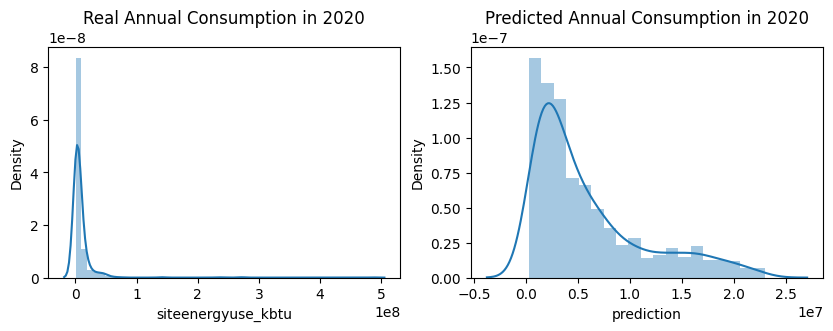

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

df_2020 = df_2020_2021[df_2020_2021['datayear'] == 2020]

sns.distplot(df_2020['siteenergyuse_kbtu'], ax=axes[0])
sns.distplot(df_2020['prediction'], ax=axes[1])

axes[0].set_title('Real Annual Consumption in 2020')
axes[1].set_title('Predicted Annual Consumption in 2020')
plt.show()

<ipython-input-87-9b5508376ef7>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2021['siteenergyuse_kbtu'], ax=axes[0])
<ipython-input-87-9b5508376ef7>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2021['prediction'], ax=axes[1])


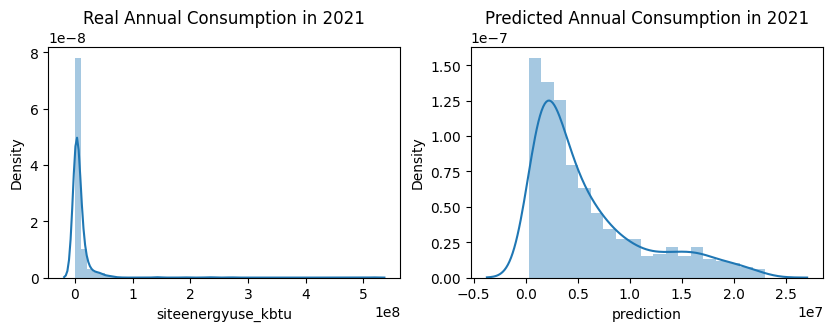

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

df_2021 = df_2020_2021[df_2020_2021['datayear'] == 2021]

sns.distplot(df_2021['siteenergyuse_kbtu'], ax=axes[0])
sns.distplot(df_2021['prediction'], ax=axes[1])

axes[0].set_title('Real Annual Consumption in 2021')
axes[1].set_title('Predicted Annual Consumption in 2021')
plt.show()

**3. Now, let's plot annual consumption in 2020 and 2021 years on the map to see the differnce between actual and predicted data.**

---
*If running the next cell leads to an error, please upload the files under the third link. Unzip them and add the files to the folder on your left (under the key button). Run again*

---




In [ ]:
#https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73 - code inspo
#https://data-seattlecitygis.opendata.arcgis.com/ - geodata
#https://data-seattlecitygis.opendata.arcgis.com/datasets/f0ec3640acef4a029ccb7eaa9de43eef_0/explore?location=47.577473%2C-122.309364%2C11.26 - map data


df = df_2020_2021
df = df_2020_2021[['zipcode', 'latitude', 'longitude', 'siteenergyuse_kbtu', 'prediction', 'datayear', 'Multifamily', 'Nonresidential', 'Other']]
seattle_county_map = gpd.read_file('/content/MHA_Fee_Areas.shp')
# seattle_county_map.to_crs(epsg=4326).plot()

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df,
                          crs = crs,
                          geometry = geometry)
geo_df.drop(geo_df[geo_df['siteenergyuse_kbtu']== 0].index, inplace=True)

geo_df['siteenergyuse_kbtu_log'] = np.log(geo_df['siteenergyuse_kbtu'])
geo_df['prediction_log'] = np.log(geo_df['prediction'])


/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:196: RuntimeWarning: /content/MHA_Fee_Areas.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
df_2019 = df_2016_2019_train[['zipcode', 'latitude', 'longitude', 'siteenergyuse_kbtu', 'datayear', 'Multifamily', 'Nonresidential', 'Other']]
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df_2019['longitude'], df_2019['latitude'])]

geo_df_2019 = gpd.GeoDataFrame(df_2019,
                          crs = crs,
                          geometry = geometry)
geo_df_2019.drop(geo_df_2019[geo_df_2019['siteenergyuse_kbtu']== 0].index, inplace=True)

geo_df_2019['siteenergyuse_kbtu_log'] = np.log(geo_df_2019['siteenergyuse_kbtu'])

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<ipython-input-90-5f56ed313699>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')


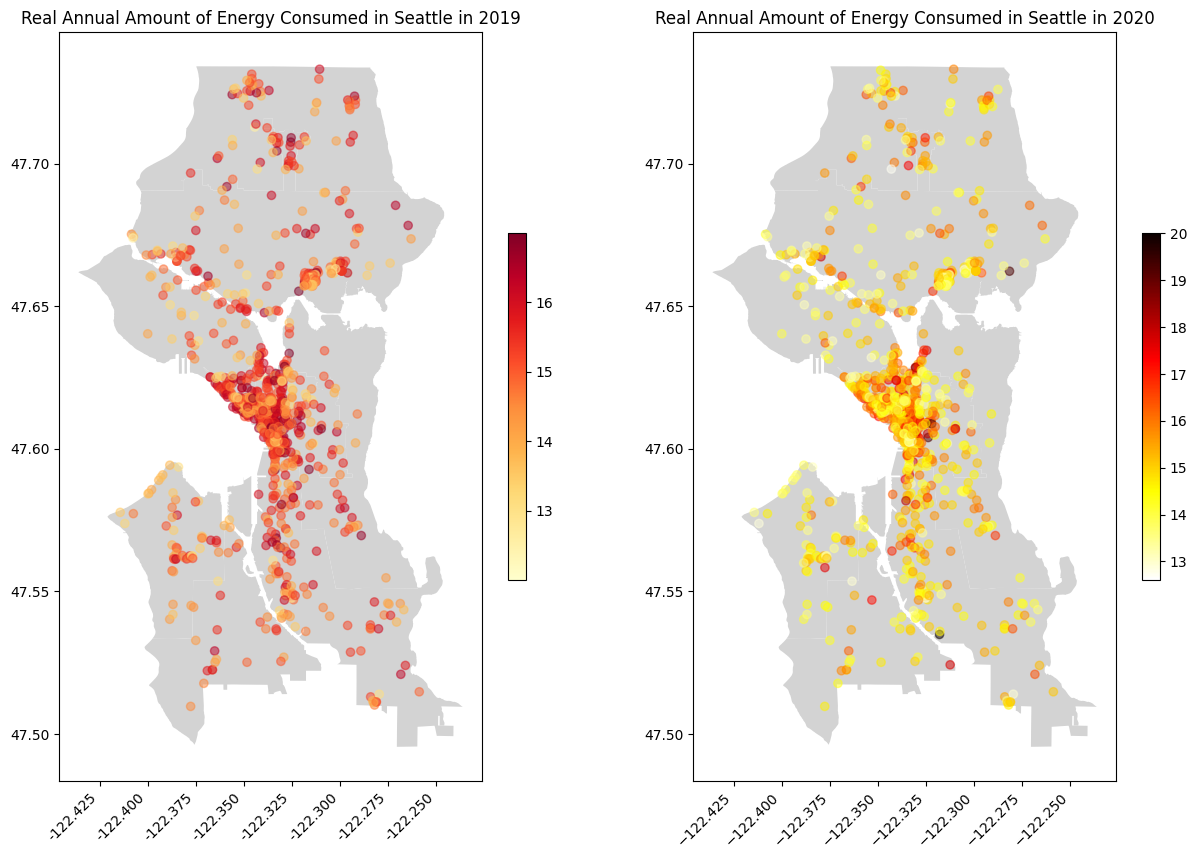

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,15))

geo_df_2019 = geo_df_2019[geo_df_2019['datayear'] == 2019]
geo_df_2020 = geo_df[geo_df['datayear'] == 2020]
seattle_county_map.to_crs(epsg=4326).plot(ax=ax[0], color='lightgrey')

geo_df_2019.plot(column = 'siteenergyuse_kbtu_log', ax=ax[0], cmap = 'YlOrRd',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)
ax[0].set_title('Real Annual Amount of Energy Consumed in Seattle in 2019')

label_format = '{:,.3f}'
ticks_loc = ax[0].get_xticks().tolist()
ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')

seattle_county_map.to_crs(epsg=4326).plot(ax=ax[1], color='lightgrey')
geo_df_2020.plot(column = 'siteenergyuse_kbtu_log', ax=ax[1], cmap = 'hot_r',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)
ax[1].set_title('Real Annual Amount of Energy Consumed in Seattle in 2020')
plt.xticks(rotation=45, ha='right')
plt.show()
#plt.savefig('heat_map_2019-20')

<ipython-input-91-79fa15c195a0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')


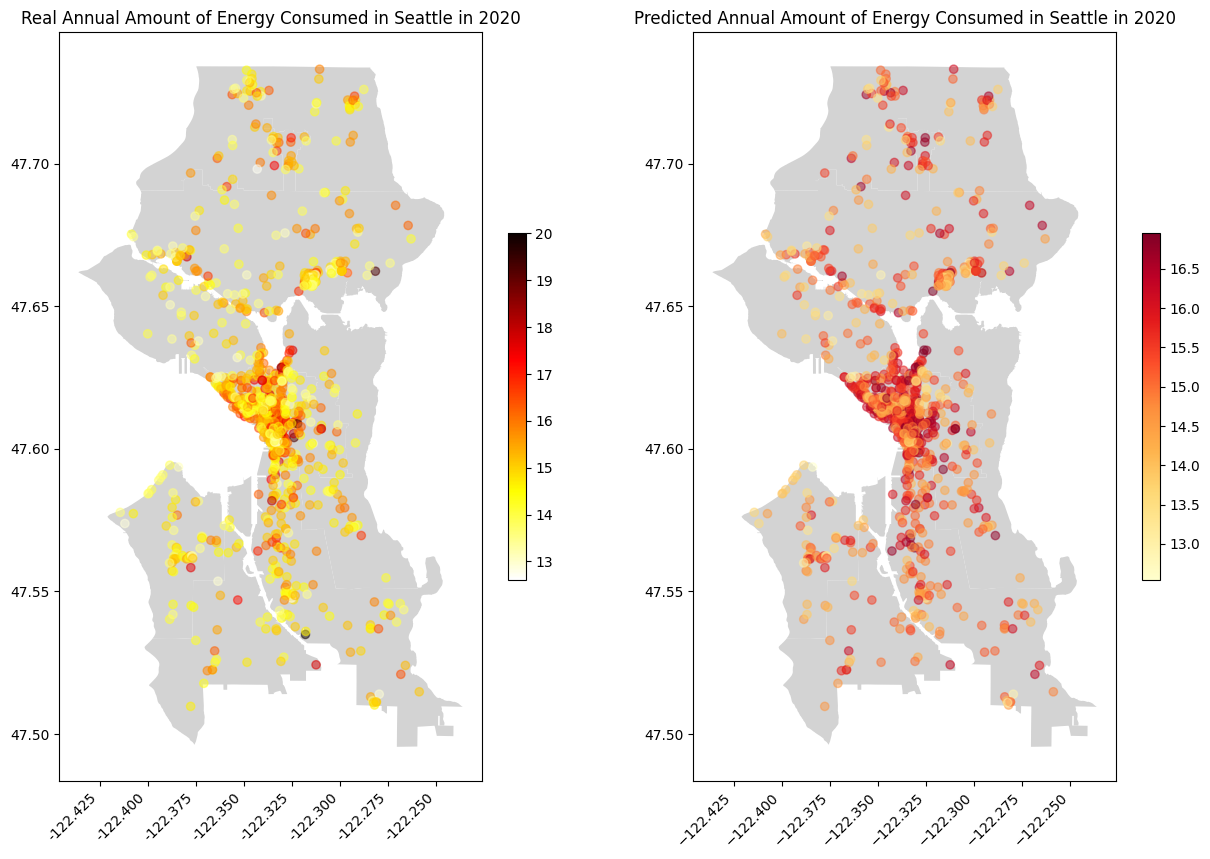

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,15))

geo_df_2020 = geo_df[geo_df['datayear'] == 2020]
seattle_county_map.to_crs(epsg=4326).plot(ax=ax[0], color='lightgrey')
geo_df_2020.plot(column = 'siteenergyuse_kbtu_log', ax=ax[0], cmap = 'hot_r',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)
ax[0].set_title('Real Annual Amount of Energy Consumed in Seattle in 2020')

label_format = '{:,.3f}'
ticks_loc = ax[0].get_xticks().tolist()
ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')

seattle_county_map.to_crs(epsg=4326).plot(ax=ax[1], color='lightgrey')
geo_df_2020.plot(column = 'prediction_log', ax=ax[1], cmap = 'YlOrRd',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)
ax[1].set_title('Predicted Annual Amount of Energy Consumed in Seattle in 2020')
plt.xticks(rotation=45, ha='right')
plt.show()
#plt.savefig('heat_map_2020')

<ipython-input-92-18c97b6b8b44>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')


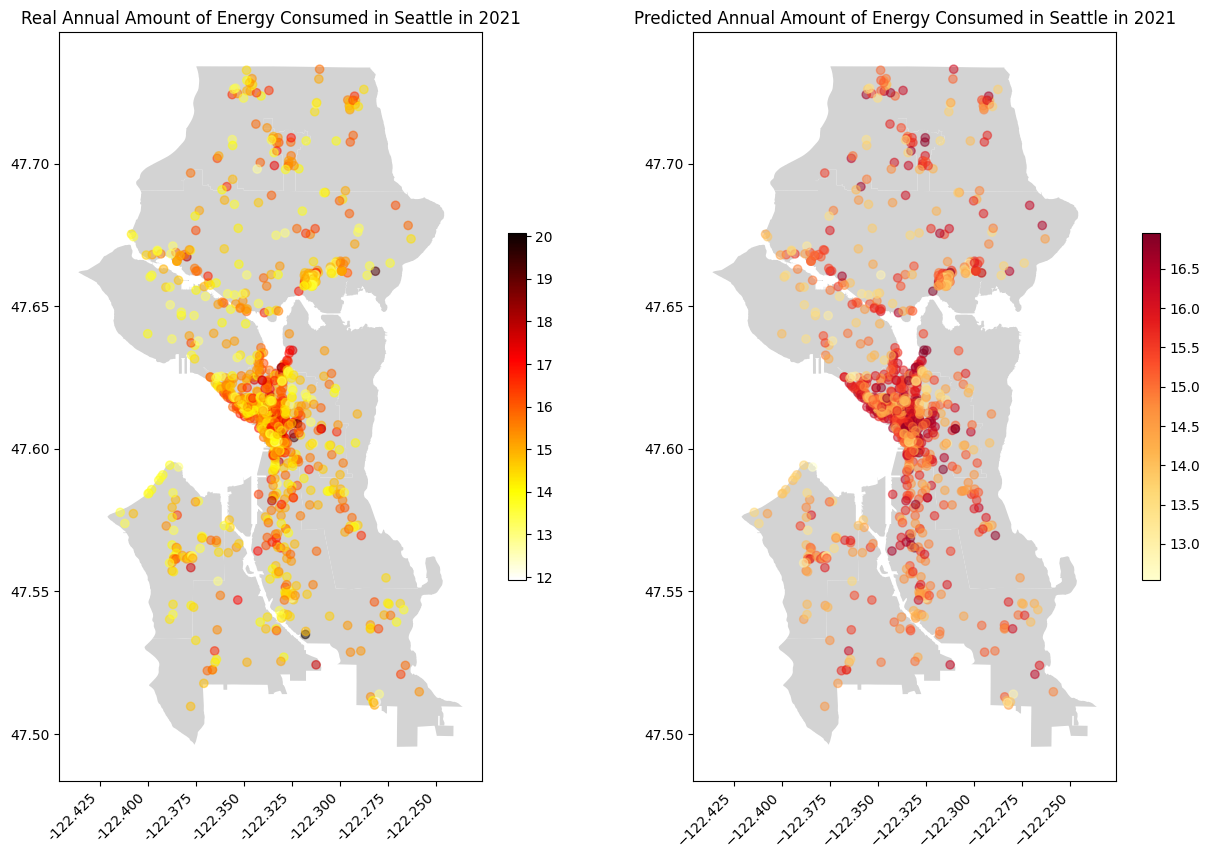

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,15))

geo_df_2021 = geo_df[geo_df['datayear'] == 2021]
seattle_county_map.to_crs(epsg=4326).plot(ax=ax[0], color='lightgrey')
geo_df_2021.plot(column = 'siteenergyuse_kbtu_log', ax=ax[0], cmap = 'hot_r',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)

seattle_county_map.to_crs(epsg=4326).plot(ax=ax[1], color='lightgrey')
geo_df_2021.plot(column = 'prediction_log', ax=ax[1], cmap = 'YlOrRd',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)

label_format = '{:,.3f}'
ticks_loc = ax[0].get_xticks().tolist()
ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')

ax[0].set_title('Real Annual Amount of Energy Consumed in Seattle in 2021')
ax[1].set_title('Predicted Annual Amount of Energy Consumed in Seattle in 2021')
plt.xticks(rotation=45, ha='right')
plt.show()
#plt.savefig('heat_map_2021')


<ipython-input-93-f74dff4ff165>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')


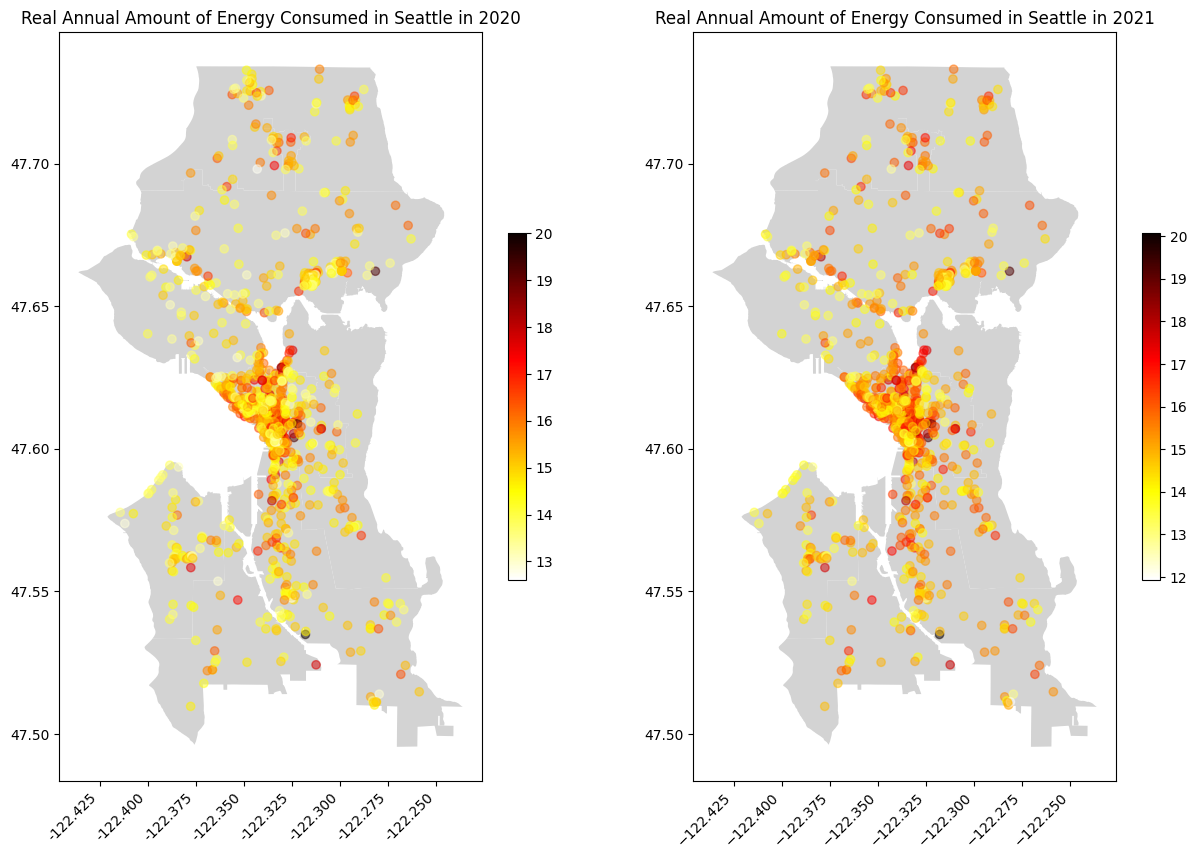

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,15))

geo_df_2020 = geo_df[geo_df['datayear'] == 2020]
geo_df_2021 = geo_df[geo_df['datayear'] == 2021]
seattle_county_map.to_crs(epsg=4326).plot(ax=ax[0], color='lightgrey')
geo_df_2020.plot(column = 'siteenergyuse_kbtu_log', ax=ax[0], cmap = 'hot_r',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)
ax[0].set_title('Real Annual Amount of Energy Consumed in Seattle in 2020')

label_format = '{:,.3f}'
ticks_loc = ax[0].get_xticks().tolist()
ax[0].set_xticklabels([label_format.format(x) for x in ticks_loc], rotation=45, ha='right')

seattle_county_map.to_crs(epsg=4326).plot(ax=ax[1], color='lightgrey')
geo_df_2021.plot(column = 'siteenergyuse_kbtu_log', ax=ax[1], cmap = 'hot_r',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)
ax[1].set_title('Real Annual Amount of Energy Consumed in Seattle in 2021')
plt.xticks(rotation=45, ha='right')
plt.show()
#plt.savefig('heat_map_2020-21')

Number of businesses with increased power consumption, with values above the original scale.

In [ ]:
df = geo_df_2020[geo_df_2020['siteenergyuse_kbtu_log'] > 17]
df['Nonresidential'].value_counts()

,count
Nonresidential,
True,57
False,12


In [ ]:
df['Other'].value_counts()

,count
Other,
False,57
True,12


**4. Bar Chart**

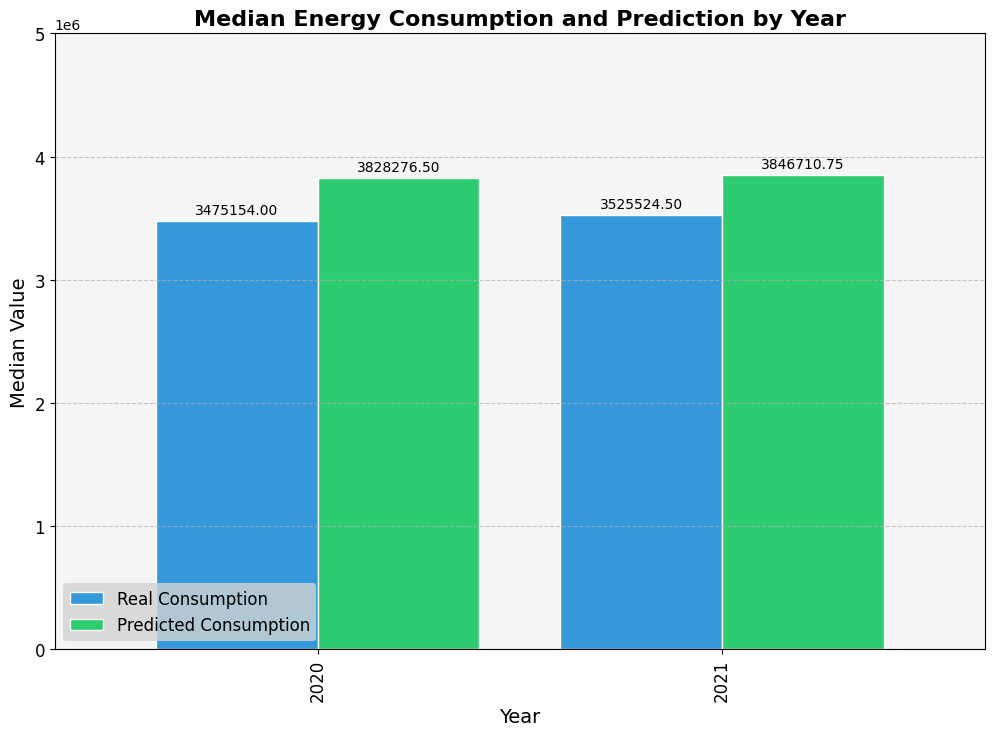

In [ ]:
df_2020_2021_bar = df_2020_2021[['datayear', 'siteenergyuse_kbtu', 'prediction']]
grouped_data = df_2020_2021_bar.groupby('datayear')[['siteenergyuse_kbtu', 'prediction']].median()


fig, ax = plt.subplots(figsize=(12, 8))
bars = grouped_data.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71'], width=0.8)
for bar in bars.patches:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_facecolor('#f5f5f5')

ax.set_title('Median Energy Consumption and Prediction by Year', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Median Value', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

for bar in bars.patches:
    bar.set_edgecolor('white')

legend = ax.legend(["Real Consumption", "Predicted Consumption"], loc='lower left', fontsize=12, facecolor='lightgray')
legend.get_frame().set_linewidth(0)

ax.set_ylim(bottom=0, top=5000000)

plt.show()
#plt.savefig('median_consump')

#**Conclusions**


We assumed going into this project that the lockdown would have a larger effect on the energy usage in the city than we observed. We had initially guessed we would observe energy usage had gone down. This was mainly due to our experiences in the lockdown, and how ravaged and empty Seattle became for large portions of time. Our analysis seems to support this hypothesis:


● Our analysis shows that there is a clear difference in energy expenditure in the city of Seattle from the predicted and observed values. Our model predicted that years 2020 and 2021 would use 9.2% and 8.3% more energy than observed.
While the training and predicted data have no zero values in energy usage for a given year, the observed dataset had several.


● Due to what these zeros symbolize, we didn't consider them outliers as it is both believable and probable that at least a few large buildings shuttered over lockdown.  The mean and median values were higher in our observed dataset than in our predicted model. This is very interesting as it is at first at odds with our previous observations.


● The standard deviation for the observed set is also a factor of 10 larger than the predicted set. This shows that the actual data became more erratic overtime, with a larger spread in both positive and negative directions.


Overall, this seems to indicate an overall slowing of growth within the city. The erratic nature of the lockdown caused some businesses to shutter and expend no energy, while others continued to grow. Our model shows that the preference was for reduced energy usage across the city as whole, of around 9% from what it would have been without Covid.
